DOMAIN: Industrial safety. NLP based Chatbot.

•CONTEXT: The  database  comes  fromone  of  the  biggest  industry  in  Brazil  and  in  the  world.  It  is  an  urgent  need  for  industries/companies  around  the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

•DATA DESCRIPTION:This  The  database  is  basically  records  of  accidents  from12  different  plants  in  03  different  countrieswhich  every  line  in  the  data  is  an occurrence of an accident.

Columns description: 

*  Data: timestamp or time/date information
*  ‣Countries: which country the accident occurred (anonymised)
*  ‣Local: the city where the manufacturing plant is located (anonymised)
*  ‣Industry sector: which sector the plant belongs to
*  ‣Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
*  ‣Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
* ‣Genre: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.




Link to download the dataset: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database[ for your reference only ]



•PROJECT OBJECTIVE:Design  a  ML/DL  based  chatbot  utility  which  can  help  the  professionals  to  highlight  the  safety  risk  as  per  the  incident description.

# Milestone - 1

In [1]:
#importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy.sparse.linalg
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('stopwords')
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from gensim.models import Word2Vec
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

## Step 1: Import the data

In [3]:
df = pd.read_csv('Industrial_Data_Set.csv')
df.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [4]:
df['Description'].iloc[2]

'In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of \u200b\u200bthe left foot of the collaborator causing the injury.'

In [5]:
print("shape of the dataset",df.shape)

shape of the dataset (425, 11)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


**Insights**



1. There are 11 columns and 425 rows in raw data
2. No Null values found 
3. All the columns except unnamed:0 (index column) are categorical


Among the 11 columns, Unnamed:0 is a index column - **Can be dropped**

Data column contains date value - **Typo needs to corrected**

Countries and Local column tells about the location of accident 

Genre column contains gender details- **Typo needs to corrected**

Accident level and Potential accident level are metric of severity of accident

Employee or Third Party indicates employee type - **Column should be renamed to Employee type  for user readability**

Description explaines how accident happened






## Step 2: Data cleansing

In [7]:
#remove duplicates in dataset 
def dropduplicates(): 
    if(df.duplicated().sum()==0):
        print("No Duplicates")
    else:
        print("Dropping",df.duplicated().sum()," duplicates ")
        df.drop_duplicates(keep='first', inplace=True)
    

#Drop unwanted columns in dataset
def dropunwantedcolumns(column): 
    if (column != ''):
        df.drop(column, axis=1,inplace=True)
        print("Dropped unwanted column -",column)


#Checks for missing value and unexpected values and impute with relevant data
def check_missingvalues(dataframe): 
    missingvalue = False
    unexpected_values = ["n/a", "na", "--", " ","?","-","@","#","n-a"]

    for feature in dataframe.columns:
        #check for NaN values 
        if(dataframe[feature].isnull().sum()!=0 or dataframe[feature].isna().sum()!=0 ):
            print("Data missing in column", feature)
            missingvalue= True    
        #check for unexpected values like special characters.     
        if(not dataframe[dataframe[feature].isin(unexpected_values)].empty):  
            print("Unexpected value found in",feature,"column in the indices ", dataframe[dataframe[feature].isin(unexpected_values)].index)
            #changing unexpected values to NaN
            df.replace(unexpected_values,np.nan, inplace=True)  
            missingvalue= True 
    if(not missingvalue):
        print("No missing value in dataframe")
    else:
        print("Missing Values Found")

#Get unique values for the features
def get_uniquevalues(x):
    for feature in x:
        print(feature ,pd.unique(df[feature]),"\n")

In [8]:
print("Drop unwanted columns")
print("-------"*3)
dropunwantedcolumns('Unnamed: 0')
print("\n\n")

print(" Duplicates check")
print("------"*3)
dropduplicates()
print("\n\n")



print("Checking Missing Values")
print("--------"*3)
check_missingvalues(df)
print("\n\n")

print("Renaming column name for better readability")
print("--------"*6)
df.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender', 'Employee or Third Party':'Employee type'}, inplace=True)
print(df.columns)
print("\n\n")

print("Getting Unique values in the dataset")
print("------"*6)
get_uniquevalues(df.columns[1:-1]) #ignoring date and description column as they have more non-unique values

Drop unwanted columns
---------------------
Dropped unwanted column - Unnamed: 0



 Duplicates check
------------------
Dropping 7  duplicates 



Checking Missing Values
------------------------
No missing value in dataframe



Renaming column name for better readability
------------------------------------------------
Index(['Date', 'Country', 'Local', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Gender', 'Employee type', 'Critical Risk',
       'Description'],
      dtype='object')



Getting Unique values in the dataset
------------------------------------
Country ['Country_01' 'Country_02' 'Country_03'] 

Local ['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12'] 

Industry Sector ['Mining' 'Metals' 'Others'] 

Accident Level ['I' 'IV' 'III' 'II' 'V'] 

Potential Accident Level ['IV' 'III' 'I' 'II' 'V' 'VI'] 

Gender ['Male' 'Female'] 

Employee type ['Third Party' 'Emplo

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 424
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Date                      418 non-null    object
 1   Country                   418 non-null    object
 2   Local                     418 non-null    object
 3   Industry Sector           418 non-null    object
 4   Accident Level            418 non-null    object
 5   Potential Accident Level  418 non-null    object
 6   Gender                    418 non-null    object
 7   Employee type             418 non-null    object
 8   Critical Risk             418 non-null    object
 9   Description               418 non-null    object
dtypes: object(10)
memory usage: 35.9+ KB


In [10]:
df.duplicated().sum()

0

**Observations** 

Accident Level and Potential Accident Level indicates the severity of the accidents as metric, Hence they can be encoded as label encoding with integers 1,2,3

Country ,local, industry , gender and employee type are categorical which needs to encoded with one-hot encoding

Since critical risk have 'others' and 'not applicable' values that needs to be further investigated on missing values

## EDA

### Univariate Analysis

#### Date Feature

In [11]:
# temporary dataframe to analyse year and month of accident occurance
analysis=pd.DataFrame()
analysis['Date'] = pd.to_datetime(df['Date'])
analysis['Year'] = analysis['Date'].apply(lambda x : x.year)
analysis['Month'] = analysis['Date'].apply(lambda x : x.month)

analysis['Weekday'] = analysis['Date'].apply(lambda x : x.day_name())
analysis.head()

,Date,Year,Month,Weekday
0,2016-01-01,2016,1,Friday
1,2016-01-02,2016,1,Saturday
2,2016-01-06,2016,1,Wednesday
3,2016-01-08,2016,1,Friday
4,2016-01-10,2016,1,Sunday


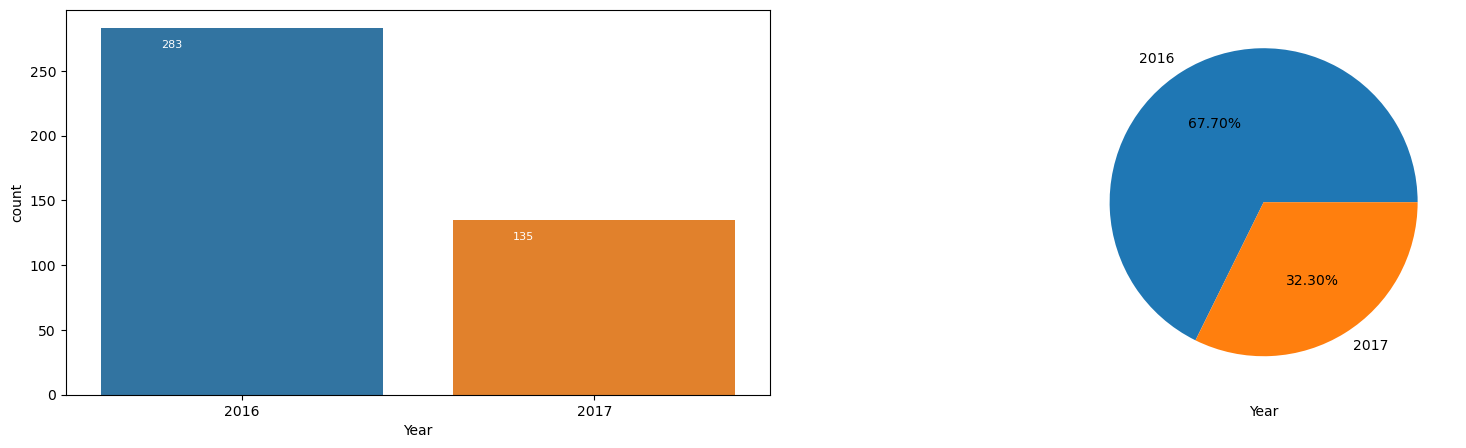

In [12]:
#Analysing the Year
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=analysis['Year'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("Year")
ax[1]=plt.pie(analysis['Year'].value_counts(), labels=['2016', '2017'], explode=(0,0),autopct = '%1.2f%%')
plt.show()

**Most accidents happend in year 2016.Count is 283 ,which is equivalent to 67.70% .**

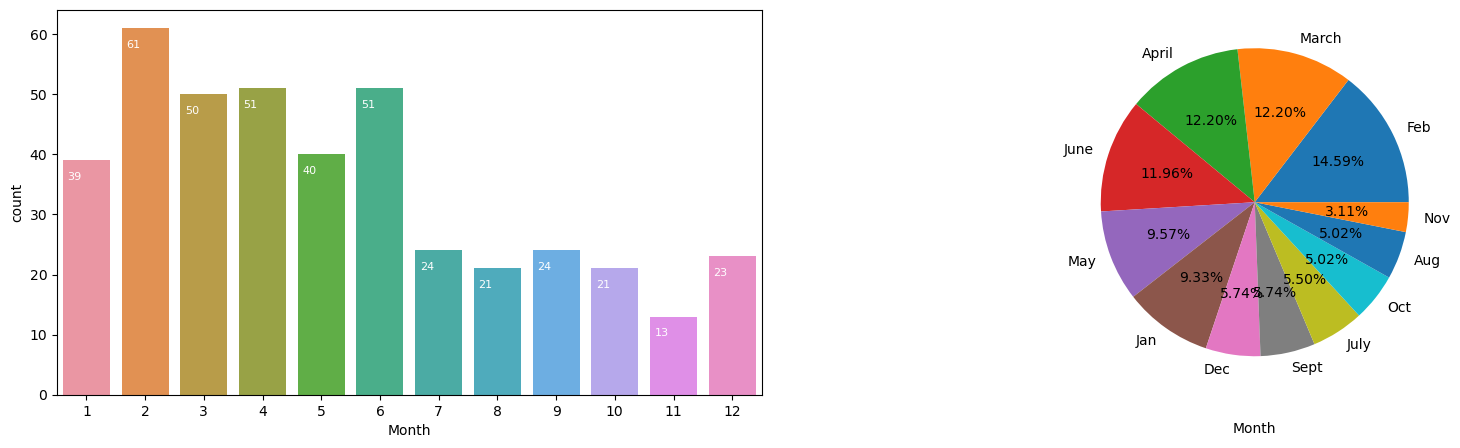

In [13]:
## Analysing the Month
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=analysis['Month'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nMonth")
ax[1]=plt.pie(analysis['Month'].value_counts(), labels=['Feb', 'March','April', 'June','May', 'Jan','Dec', 'Sept','July', 'Oct','Aug', 'Nov'], explode=(0,0,0,0,0,0,0,0,0,0,0,0),autopct = '%1.2f%%')
plt.show()

**No Trend found in the month but Most accidents happend in Feb month.Count is 61 ,which is equivalent to 14.59%**

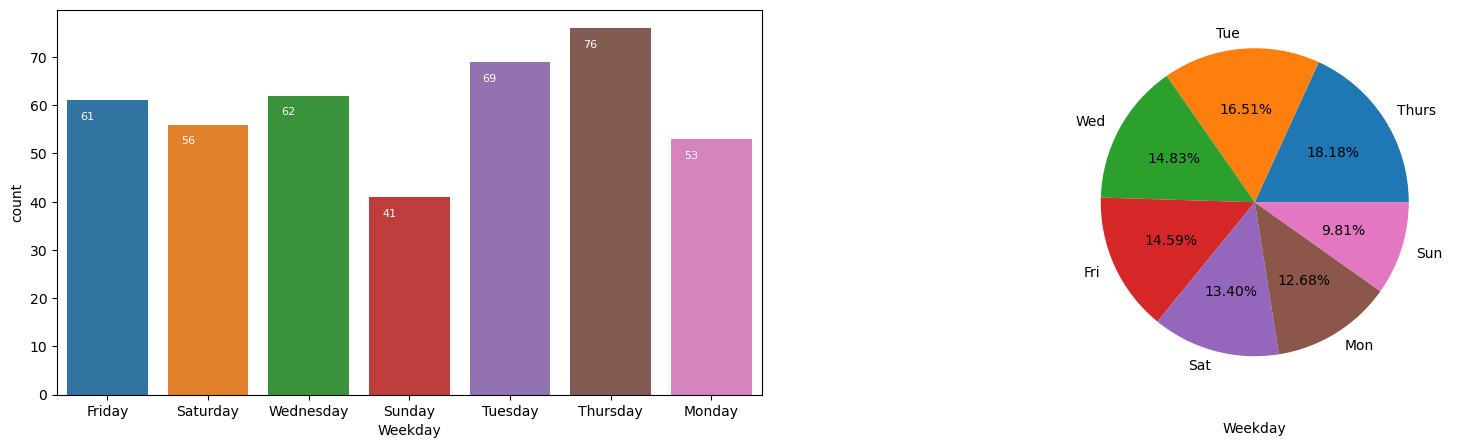

In [14]:
## Analysing Weekday
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=analysis['Weekday'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nWeekday")
ax[1]=plt.pie(analysis['Weekday'].value_counts(), labels=['Thurs', 'Tue','Wed', 'Fri','Sat', 'Mon','Sun'], explode=(0,0,0,0,0,0,0),autopct = '%1.2f%%')
plt.show()

**No Trend found in the month but Most accidents happend in Thursday .Count is 76,which is equivalent to 18.18%**

#### Country Feature Analysis

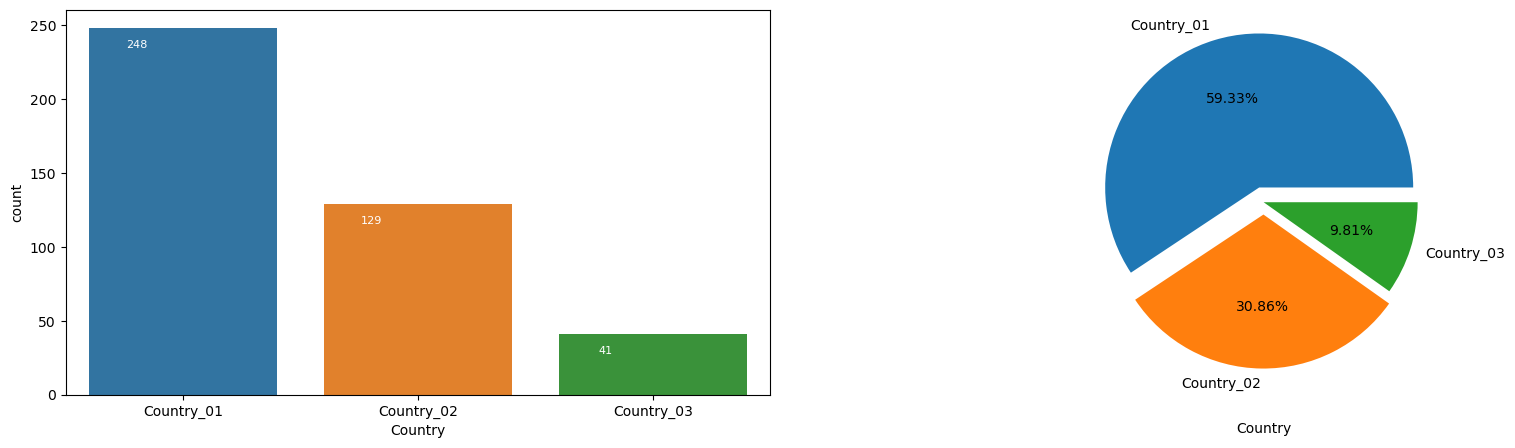

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=df['Country'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nCountry")
ax[1]=plt.pie(df['Country'].value_counts(), labels=['Country_01','Country_02','Country_03'], explode=(0.1,0.08,0),autopct = '%1.2f%%');
plt.show()

**Most accidents happened in Country_01 .Its count is 248 ,which is equivalent to 59.33% .**

#### Local Feature Analysis

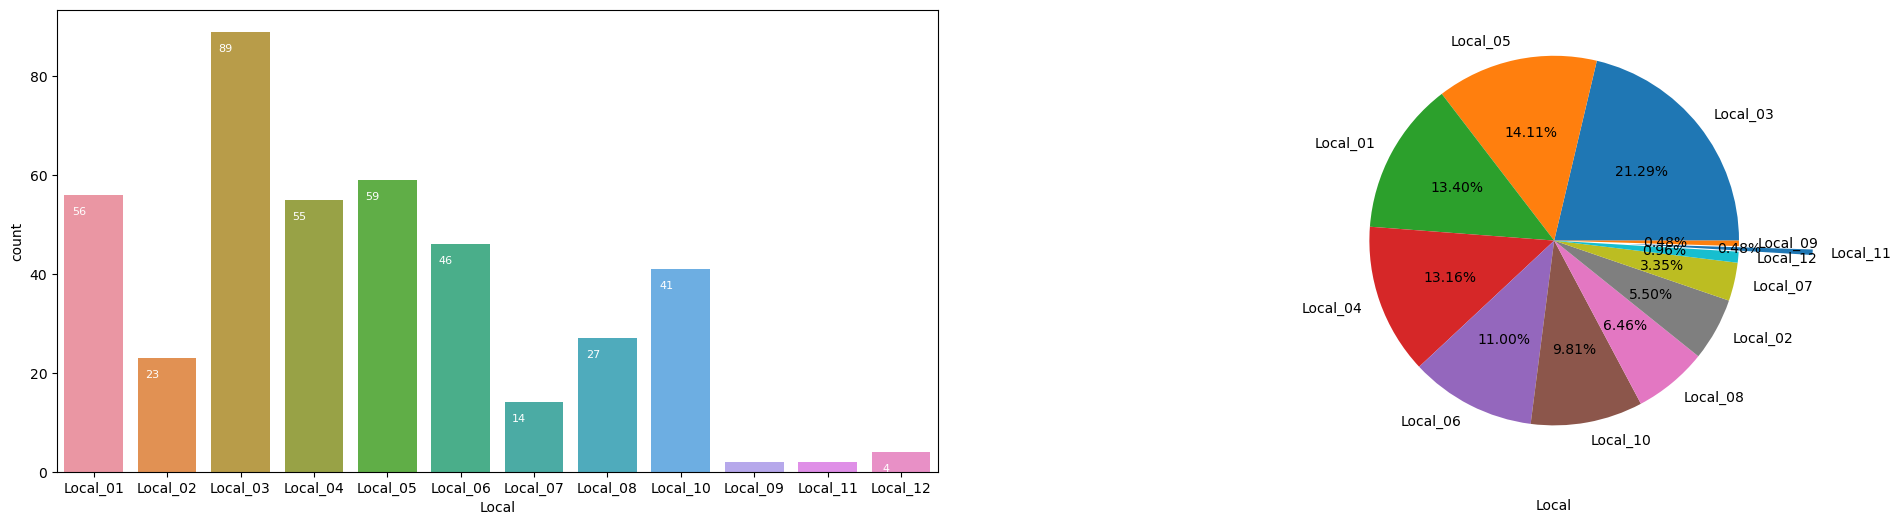

In [16]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(25,6))
count=sns.countplot(x=df['Local'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nLocal")
ax[1]=plt.pie(df['Local'].value_counts(), labels=['Local_03','Local_05','Local_01','Local_04','Local_06','Local_10','Local_08','Local_02','Local_07','Local_12','Local_11','Local_09'], explode=(0,0,0,0,0,0,0,0,0,0,0.4,0),autopct = '%1.2f%%')
plt.show()

**Most accidents happened in Local_03 .Its count is 89 ,which is equivalent to 21.29% .**

#### Industry Sector Analysis

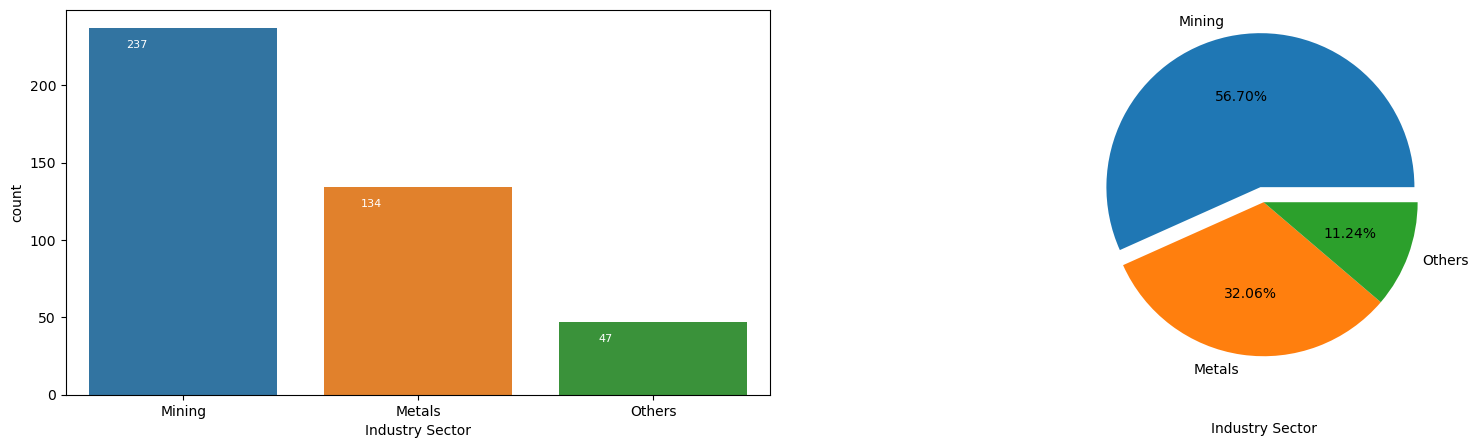

In [17]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=df['Industry Sector'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nIndustry Sector")
ax[1]=plt.pie(df['Industry Sector'].value_counts(), labels=['Mining', 'Metals', 'Others'], explode=(0.1,0,0),autopct = '%1.2f%%');
plt.show()

In [18]:
df['Industry Sector'].value_counts()

Mining    237
Metals    134
Others     47
Name: Industry Sector, dtype: int64

**Most accidents happened in mining Industry sector .Its count is 237 ,which is equivalent to 56.70%.**

#### Accident Level Analysis

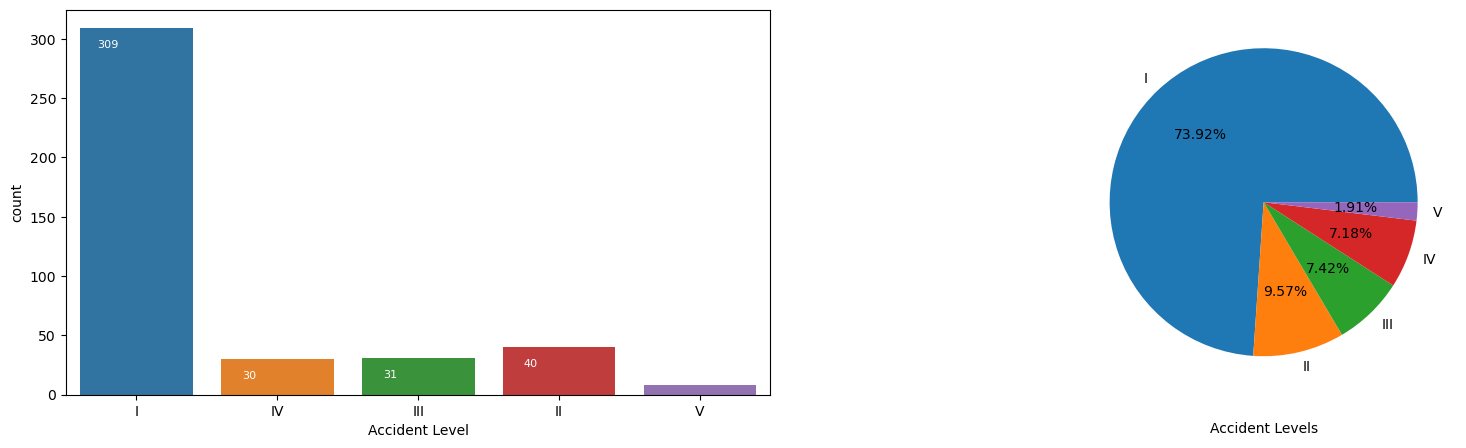

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=df['Accident Level'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nAccident Levels")
ax[1]=plt.pie(df['Accident Level'].value_counts(), labels=['I', 'II', 'III' ,'IV' ,'V'], explode=(0,0,0,0,0),autopct = '%1.2f%%')
plt.show()

::**Most accidents belongs to "Accident Level" I .Its count is 309 which is equivalent to 73.92% of total accidents.**

#### Potential Accident level Analysis

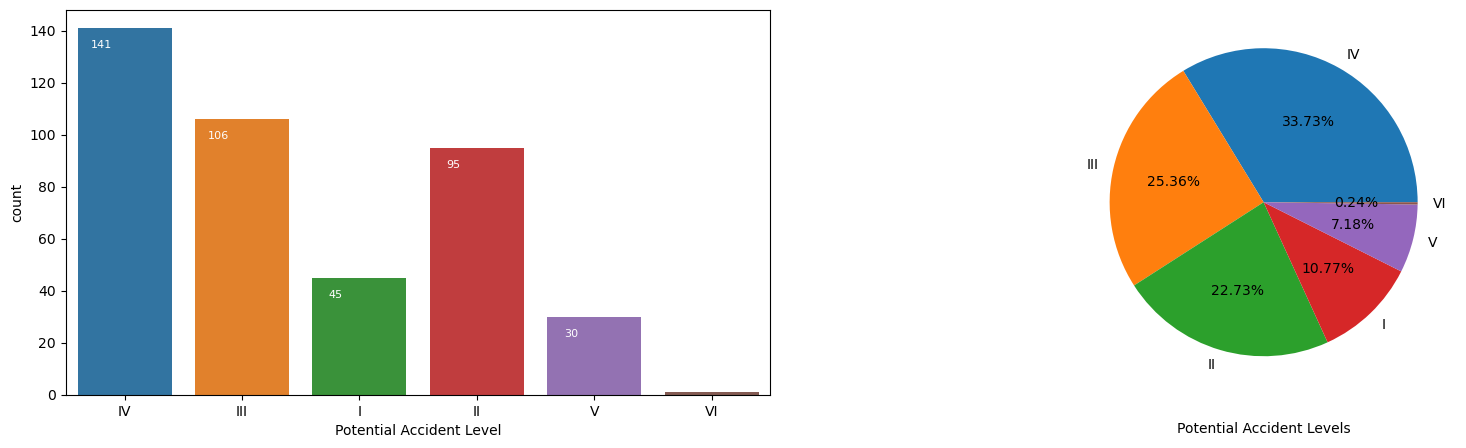

In [20]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=df['Potential Accident Level'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nPotential Accident Levels")
ax[1]=plt.pie(df['Potential Accident Level'].value_counts(), labels=['IV','III','II','I','V','VI'], explode=(0,0,0,0,0,0),autopct = '%1.2f%%')
plt.show()

**Most "Potential Accident Level" belongs to level IV .Its count is 141 which is equivalent to 33.73% of total potential accidents.**

#### Gender Feature Analysis

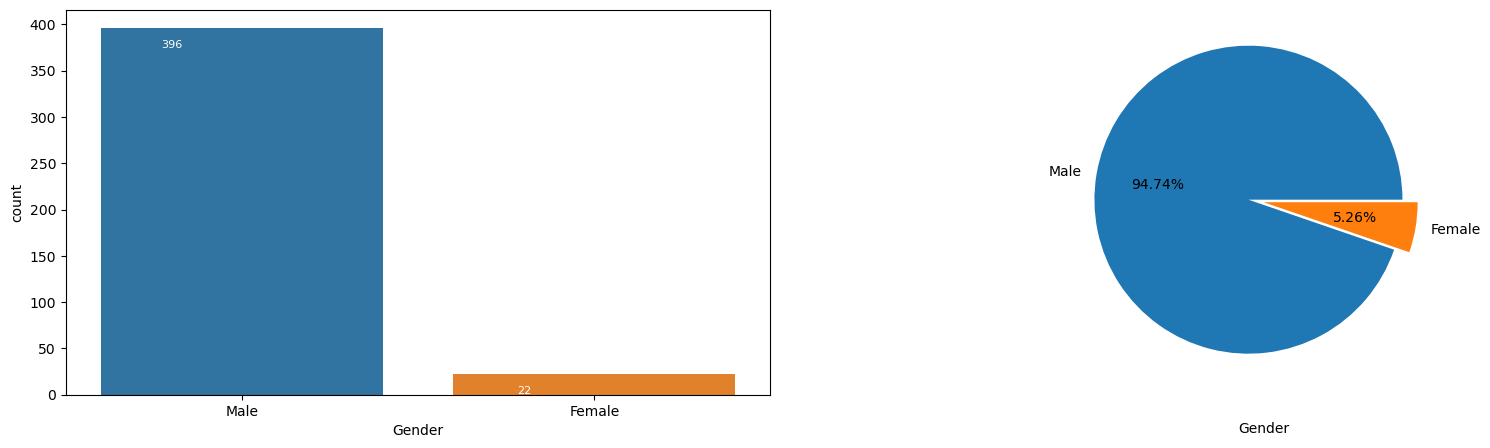

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=df['Gender'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nGender")
ax[1]=plt.pie(df['Gender'].value_counts(), labels=['Male', 'Female'], explode=(0.1,0),autopct = '%1.2f%%');
plt.show()

**Most affected wokers in accidents are male .Their count is 396 ,which is equivalent to 94.74%**

#### Employee Type Analysis

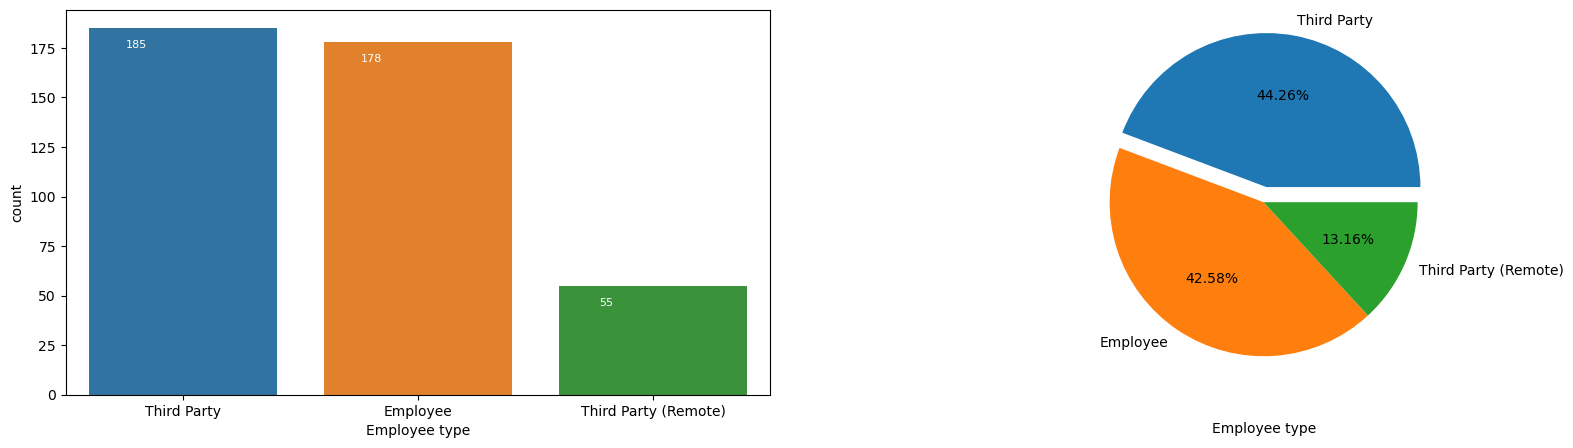

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
count=sns.countplot(x=df['Employee type'],ax=ax[0])
for p in count.patches:
    count.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
plt.xlabel("\nEmployee type")
ax[1]=plt.pie(df['Employee type'].value_counts(), labels=['Third Party', 'Employee', 'Third Party (Remote)'], explode=(0.1,0,0),autopct = '%1.2f%%');
plt.show()

**Most affected Employee type are Third party workers .Their count is 185,which is equivalent to 44.26%.**

#### Critical Risk Feature Analysis

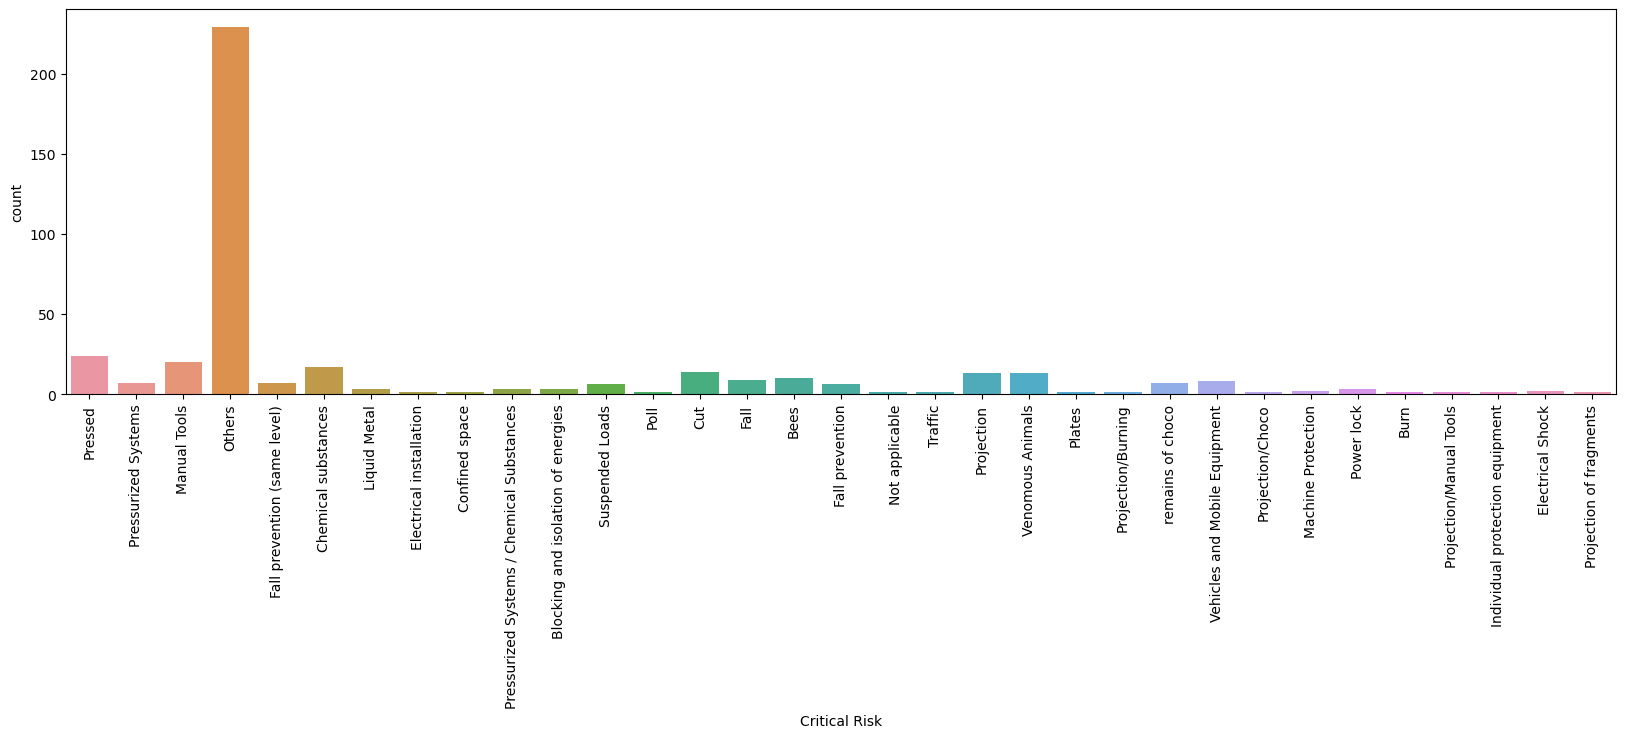

In [23]:
plt.figure(figsize=(20,5))
sns.countplot(x=df['Critical Risk'],orient='h')
plt.xticks(rotation = 'vertical')
plt.show()

**Most of the critical RIsks are Others and one Non-Applicable; So this critical risk column have 50% of missing categorization adding them as separate dependent variable X may cause bias in the model**

**Hence , Planning to append the critical risk other than 'Others' to description to reduce the dimensionality and preseve the information in critical risk**


All the features except description is analysed and findings were noted . Will do Textual pre-processing to Description and analyse that feature later

### Bivariate and Multi Variate Analysis Analysis

#### Industry Sector Vs Accident/ Potential Accident Level

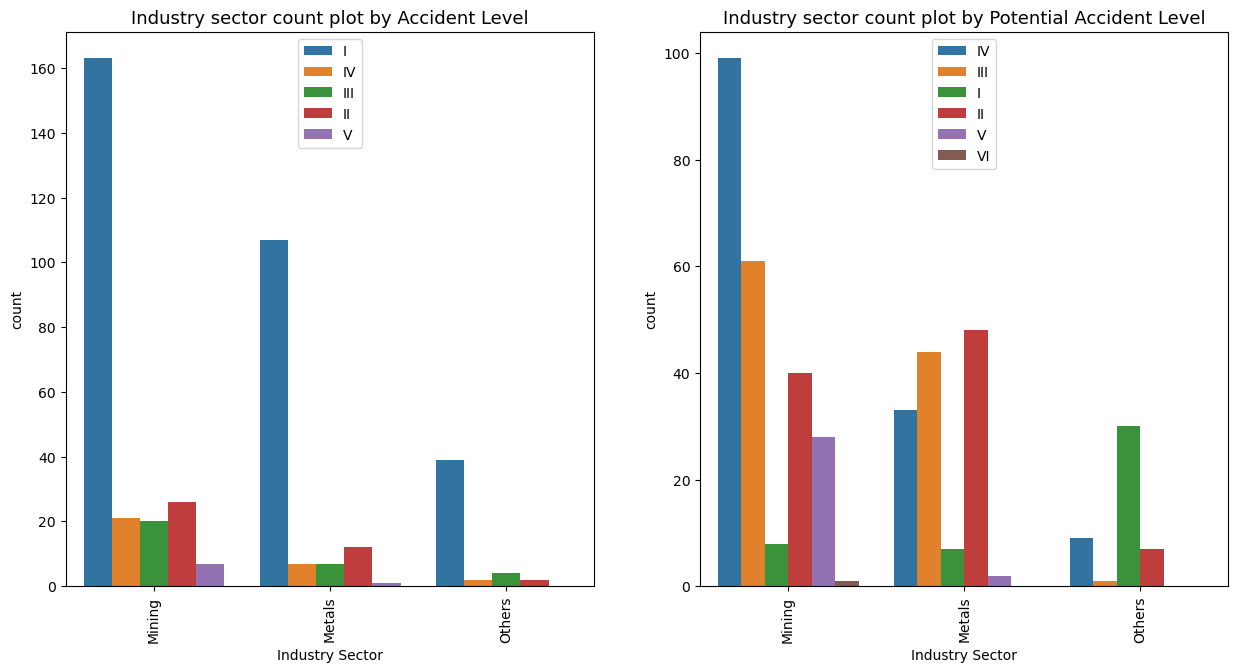

In [24]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(121)
sns.countplot(x = 'Industry Sector', data = df, ax = ax, orient = 'v',hue = 'Accident Level').set_title('Industry Sector'.capitalize() +' count plot by Accident Level',fontsize = 13)
plt.legend(labels = df['Accident Level'].unique())
plt.xticks(rotation = 90)
    
ax = fig.add_subplot(122)
sns.countplot(x ='Industry Sector' , data = df, ax = ax, orient = 'v',hue = 'Potential Accident Level').set_title('Industry Sector'.capitalize() +' count plot by Potential Accident Level', fontsize = 13)
plt.legend(labels = df['Potential Accident Level'].unique())
plt.xticks(rotation = 90)
plt.show()

**Industry Sector Vs Accident Level**

1. Accident level I is highest in all industry sector (Mining, Metals and Other).
2. Most accidents happened in Mining industry sector.
3. Others industry sector has less accidents in comparision to other industries.
4. There are very few cases for Accident level 5. Others sector didn't reported any case for this level

**Industry Sector Vs Potential Accident Level**
1. Potential Accident level 4 is highest in all industry sector (Mining, Metals and Others).
2. Most accidents happened in Mining industry sector.
3. Others industry sector has less accidents in comparision to other industries.
4. These are very few cases for Accident level 6.Metals and Others sector didnot reported case for this accident level

#### Country Vs Accident/ Potential Accident Level


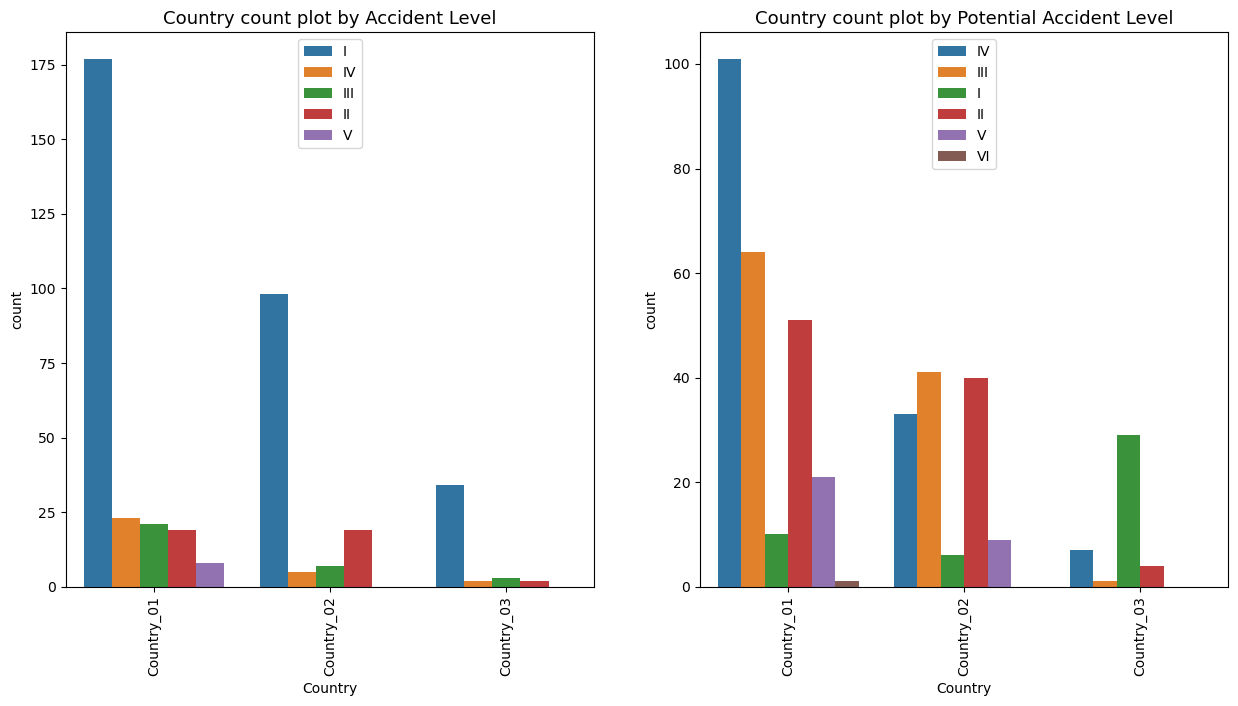

In [25]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(121)
sns.countplot(x = 'Country', data = df, ax = ax, orient = 'v',hue = 'Accident Level').set_title('Country'.capitalize() +' count plot by Accident Level',fontsize = 13)
plt.legend(labels = df['Accident Level'].unique())
plt.xticks(rotation = 90)
  
ax = fig.add_subplot(122)
sns.countplot(x ='Country' , data = df, ax = ax, orient = 'v',hue = 'Potential Accident Level').set_title('Country'.capitalize() +' count plot by Potential Accident Level',fontsize = 13)
plt.legend(labels = df['Potential Accident Level'].unique())
plt.xticks(rotation = 90)
plt.show()

**Country Vs Accident Level**
1. Accident level I is highest in all countries.
2. Most accidents happened in country 1.
3. Accident level in country 3 is lesser than other countries.


**Country Vs Potential Accident Level**
1. Potential Accident level 4 is highest in Country 1.
2. Most accidents happened in country 1.
3. Accident level in country 3 is lesser than other countries.

#### Local Vs Accident level /Potential accident level

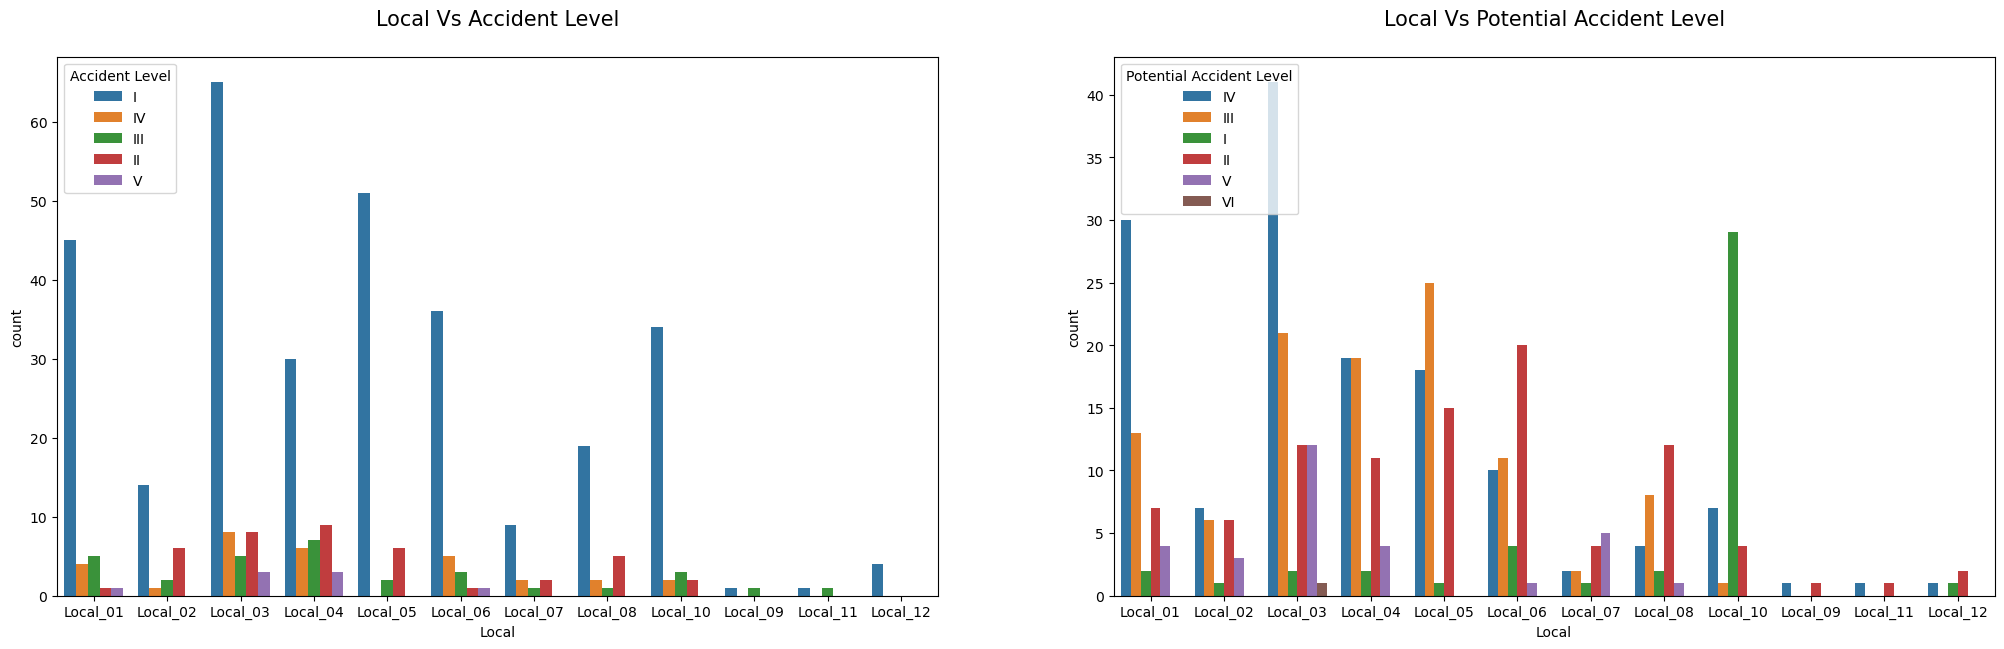

In [26]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(25,7)

sns.countplot(x=df['Local'], hue = df['Accident Level'],ax = ax1)
ax1.set_title('Local Vs Accident Level\n',fontsize = 15)

sns.countplot(x=df['Local'],hue = df['Potential Accident Level'],ax=ax2)
ax2.set_title('Local Vs Potential Accident Level\n',fontsize = 15)

plt.show()
     

**Local Vs Accident Level**
1. Accident level I is highest in almost all localities.
2. Accident level I is highest in Local 3.
3. Local 9,11 and 12 have less accidents level.

**Local Vs Potential Accident Level**
1. Potential Accident level 4 is highest in Local 3.
2. Potential Accident level 4 is higher in most localities.
3. Local 9,11 and 12 have less potential accidents level.
4. Potential Accident level 1 is highest in local 10.
5. Potential Accident level 3 is highest in local 5.

#### Country Vs Year/Employee Type and Industry Sector

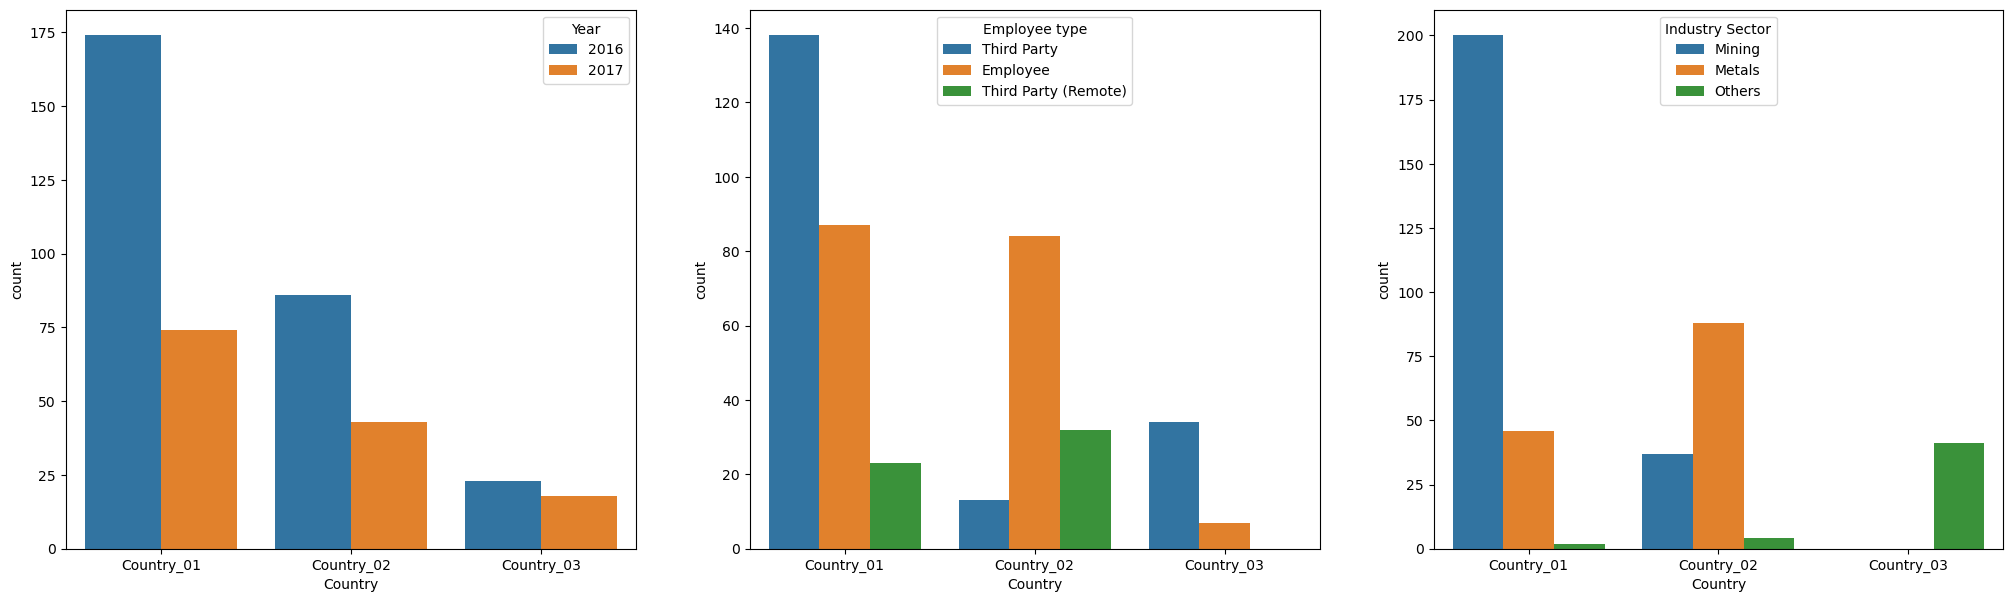

In [27]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(25,7)
sns.countplot(x=df["Country"],hue=analysis["Year"],ax = ax1);
sns.countplot(x="Country", data=df, hue="Employee type",ax = ax2);
sns.countplot(x="Country", data=df, hue="Industry Sector",ax = ax3);



1.  In 2016 and 2017 country 1 has more accidents than other countries.
2. In 2016 and 2017 country 3 has least accidents than other countries.
3. Incidents in Country_01 has Employee type of Third Party high in number.
4. Incidents in Country_02 has Employee type of Employee high in number.
5. Incidents in Country_03 has Employee type of Third Party high in number.
6. In Country_01, Incidents in Mining sector are very high.
7. In Country_02, Incidents in Metals sector are very high.
8. In Country_03, Incidents in Other sectors are very high.



#### Local Vs Employee Type

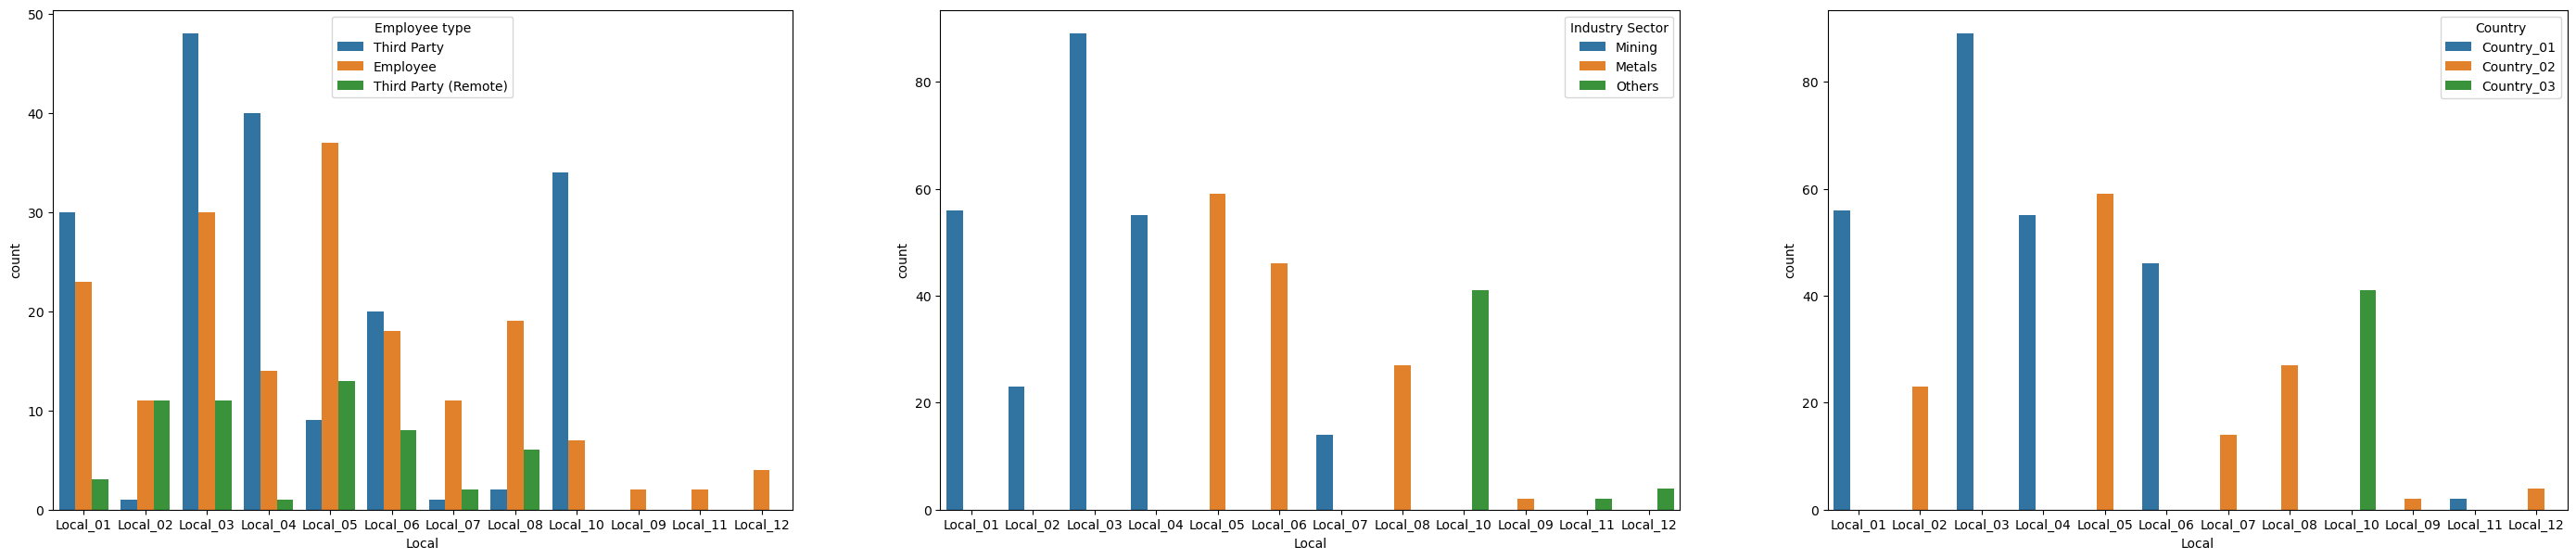

In [28]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(35,7)
sns.countplot(x=df["Local"], hue=df["Employee type"],ax = ax1);
sns.countplot(x=df["Local"],hue=df["Industry Sector"],ax = ax2);
sns.countplot(x=df["Local"],hue=df["Country"],ax = ax3);

1. Local 3 has highest no of Third Party employees
2. Local 3 has more employees than other localities.
3. Local 10 don;t have Third Party (Remote) employees.
4. Local 9,11,12 don;t have Employee and Third Party employees.
5. Local 3 has highest number of Mining industry sector.
6. Local 5 has highest number of Metals industry sector.
7. Local 1,2,3,4,7 has Mining industry sector.
8. Local 5,6,8,9 has Metals industry sector.
9. Local 10,11,12 has Others industry sector.
10. Local 3 has biggest in Country 1.
11. Local 2 has biggest in Country 1..
12. Local 1,3,4,6,11 belongs to country 1.
13. Local 2,5,7,8,9,12 belongs to country 2.
14. Local 10 belongs to country 3.

<Figure size 3500x720 with 0 Axes>

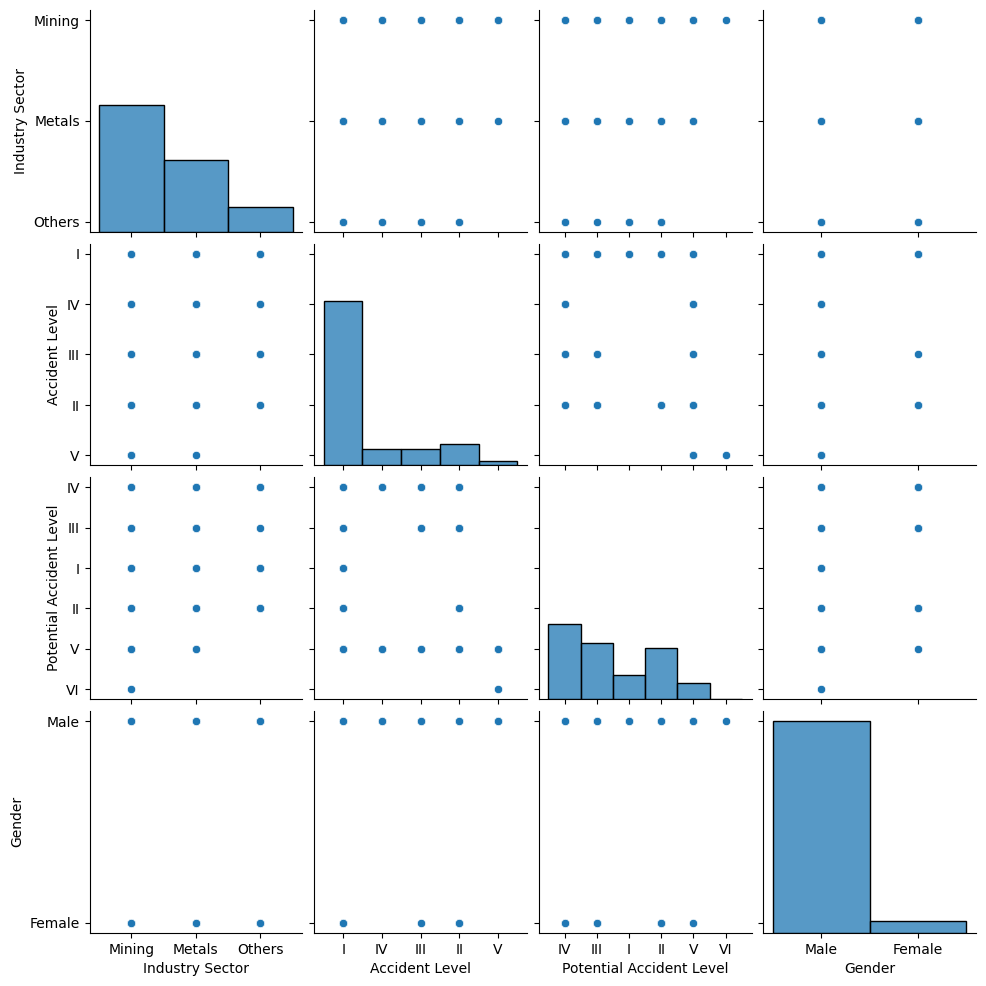

In [29]:
#sns.pairplot(df.iloc[:,1:-1])]
fig = plt.figure(figsize = (35, 7.2))
sns.pairplot(df, vars=df.columns[3:7])


Metal Industry dont have any VI level accidents

Other industry dont have potential accident level v and VI and accident level v

## Step 3: Data preprocessing (NLP Preprocessing techniques)

In [30]:
def preprocess_text(text):

    #stopwords removal
    df['Cleaned Desc'] = text.apply(lambda t: ' '.join([words for words in t.split() if words not in stop]) )

    #lemmetization
    lemmatizer = WordNetLemmatizer()
    df['Cleaned Desc']=df['Cleaned Desc'].apply(lambda t: ' '.join([lemmatizer.lemmatize(word) for word in t.split(" ")]))

    #Convert to lowercase
    df['Cleaned Desc'] = df['Cleaned Desc'].apply(lambda s: s.lower())

    #Remove Special characters and Numbers
    pattern = r'([^a-zA-Z\s]+?)'
    df['Cleaned Desc']  = df['Cleaned Desc'].apply(lambda s : re.sub(pattern,"",s))

    # remove extra white spaces
    df['Cleaned Desc']  = df['Cleaned Desc'].apply(lambda s: s.strip()) 

    return df['Cleaned Desc']

stop=set(stopwords.words('english'))     
df['Cleaned Desc']= preprocess_text(df['Description'])

In [31]:
df[['Cleaned Desc','Description']]

,Cleaned Desc,Description
0,while removing drill rod jumbo maintenance su...,While removing the drill rod of the Jumbo 08 f...
1,during activation sodium sulphide pump piping ...,During the activation of a sodium sulphide pum...
2,in substation milpo located level collaborato...,In the sub-station MILPO located at level +170...
3,being am approximately nv cx ob personnel be...,Being 9:45 am. approximately in the Nv. 1880 C...
4,approximately am circumstance mechanic anthon...,Approximately at 11:45 a.m. in circumstances t...
...,...,...
420,being approximately am approximately lifting ...,"Being approximately 5:00 a.m. approximately, w..."
421,the collaborator moved infrastructure office j...,The collaborator moved from the infrastructure...
422,during environmental monitoring activity area ...,During the environmental monitoring activity i...
423,the employee performed activity stripping cath...,The Employee performed the activity of strippi...


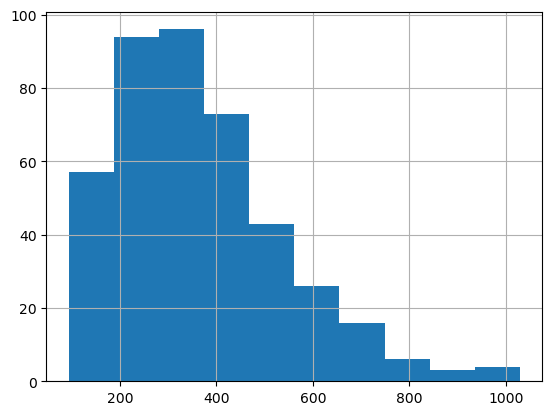

In [32]:
df['Description'].str.len().hist();


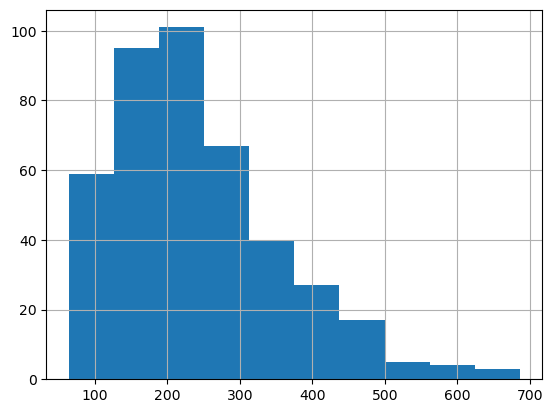

In [33]:
df['Cleaned Desc'].str.len().hist();

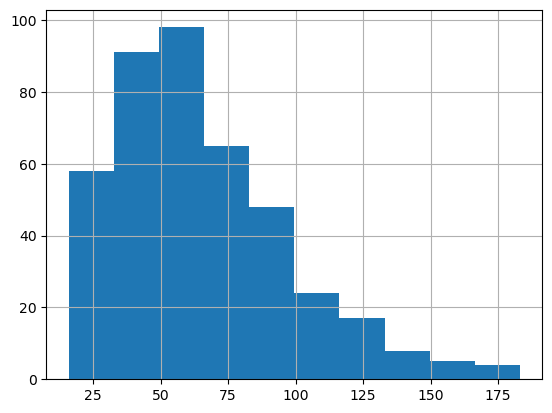

In [34]:
df['Description'].str.split().map(lambda x: len(x)).hist();

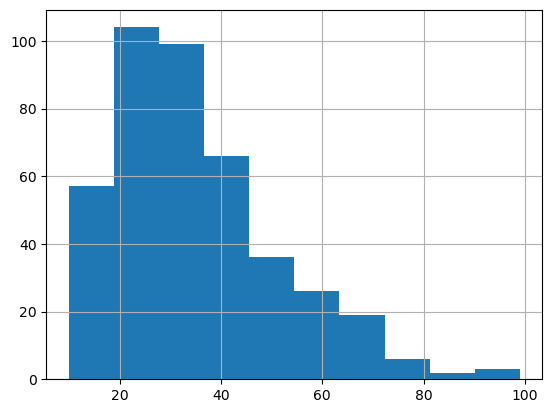

In [35]:
df['Cleaned Desc'].str.split().map(lambda x: len(x)).hist();


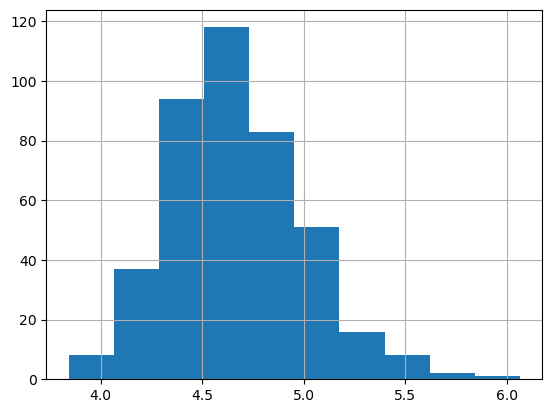

In [36]:
df['Description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist();

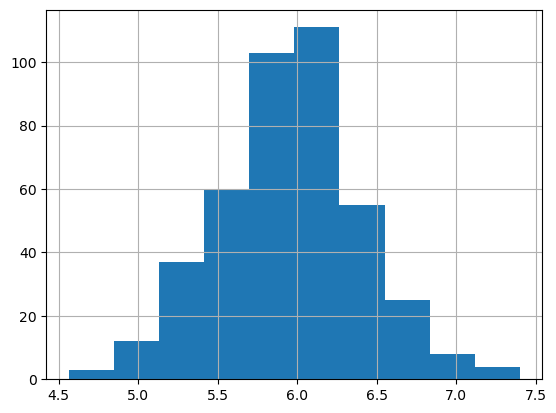

In [37]:
df['Cleaned Desc'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist();

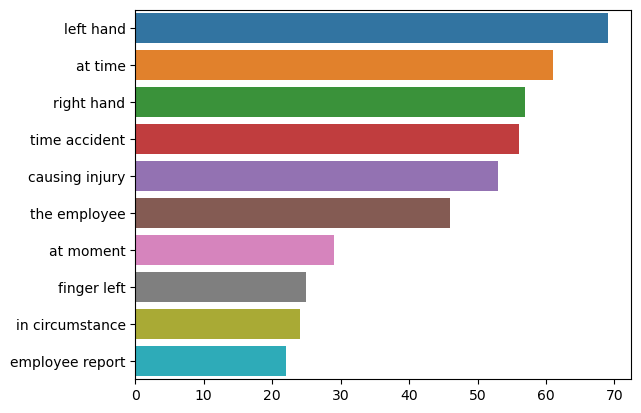

In [38]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams= get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
plot_top_ngrams_barchart(df['Cleaned Desc'],2)

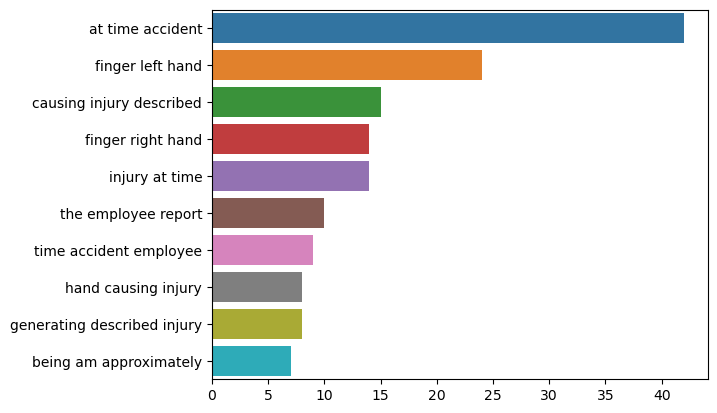

In [39]:
plot_top_ngrams_barchart(df['Cleaned Desc'],3)
     

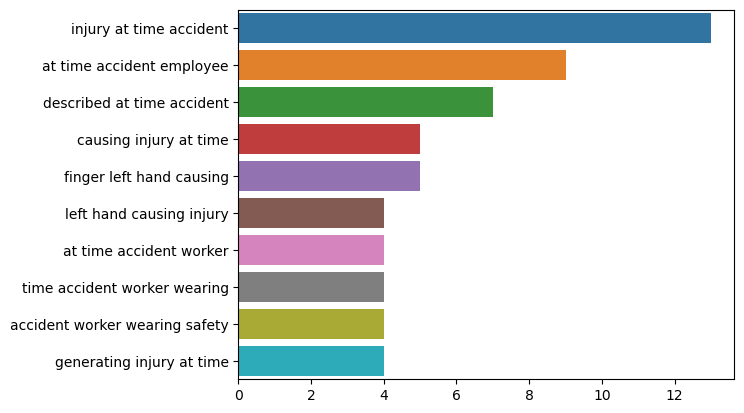

In [40]:
plot_top_ngrams_barchart(df['Cleaned Desc'],4)

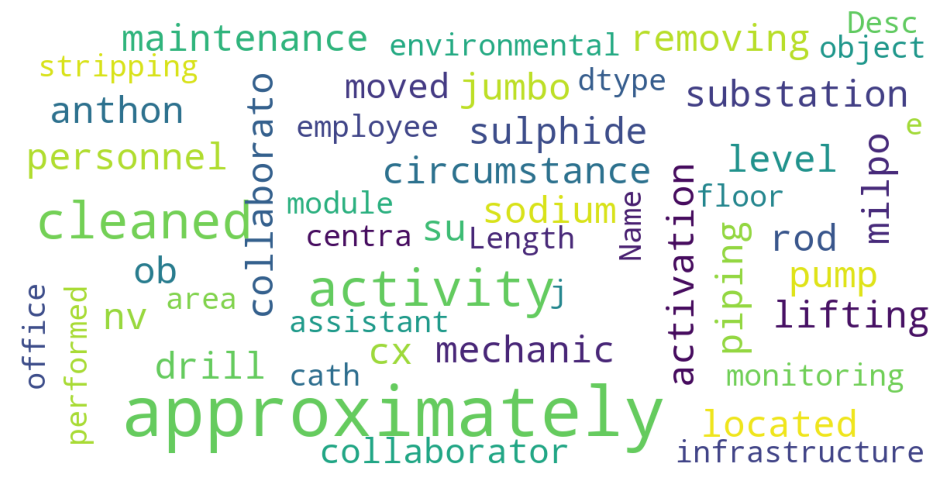

In [41]:
wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
desc = df['Cleaned Desc']
wordcloud=wordcloud.generate(str(desc))

fig = plt.figure(1, figsize=(12, 12)) 
plt.axis('off')
 
plt.imshow(wordcloud)
plt.show()

## Step 4: Data preparation - Cleansed data in .xlsx or .csv file

### Label Encoding

In [42]:
replace_struc = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5}
df['Accident Level'] = df['Accident Level'].map(replace_struc)
replace_struc = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 5} #only 1 incident for level 6 so added as level 5 as it will not make any difference
df['Potential Accident Level'] = df['Potential Accident Level'].map(replace_struc)

# Assumption 1 - Predicting accident level with description

In [43]:
X = df['Cleaned Desc']
Y = df['Accident Level']  

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=28,test_size = 0.2)

In [45]:
print("X_Train shape",X_train.shape)
print("Y_Train shape",Y_train.shape)
print("X_Test shape",X_test.shape)
print("Y_test shape",Y_test.shape)

X_Train shape (334,)
Y_Train shape (334,)
X_Test shape (84,)
Y_test shape (84,)


### Bag Of Words

In [46]:
BagofWords = CountVectorizer(analyzer='word', ngram_range=(1, 2))
BagofWords.fit(X_train)
X_train_BW = BagofWords.transform(X_train).toarray()
X_test_BW = BagofWords.transform(X_test).toarray()


#Check the vocabulory size
print("Len of Vocab",len(BagofWords.vocabulary_))
BagofWords.get_feature_names_out()[:15]

Len of Vocab 11645


array(['abdomen', 'abdomen left', 'able', 'able position', 'able remove',
       'abratech', 'abratech company', 'abrupt', 'abrupt contact',
       'abrupt movement', 'abruptly', 'abruptly dropped',
       'abruptly withdrawing', 'absorbent', 'absorbent cloth'],
      dtype=object)

In [47]:
X_train_BW[310]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### TFIDF

In [48]:
TFIDF = TfidfVectorizer(ngram_range=(1,2))
TFIDF.fit(X_train)
X_train_TFIDF = TFIDF.transform(X_train).toarray()
X_test_TFIDF = TFIDF.transform(X_test).toarray()


In [49]:
X_train_TFIDF[9]

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
X_BW = BagofWords.transform(X).toarray()
X_TFIDF = TFIDF.transform(X).toarray()

### Word2Vec

In [51]:
# Converting the words back to the sentence form for modelling
def word_vector(model,tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec
    
training = df['Cleaned Desc'].tolist() # Covnerting the text to list
training = [sentence.split(' ')  for sentence in training] # Splitting on each sentence which gives the multi dimensional list 
print("first sentence",np.array(training[0])) # Priting the first sentence

first sentence ['while' 'removing' 'drill' 'rod' 'jumbo' '' 'maintenance' 'supervisor'
 'proceeds' 'loosen' 'support' 'intermediate' 'centralizer' 'facilitate'
 'removal' 'seeing' 'mechanic' 'support' 'one' 'end' 'drill' 'equipment'
 'pull' 'hand' 'bar' 'accelerate' 'removal' 'this' 'moment' 'bar' 'slide'
 'point' 'support' 'tightens' 'finger' 'mechanic' 'drilling' 'bar' 'beam'
 'jumbo']


### CBOW

In [52]:
CBOWmodel = Word2Vec(sentences=training, min_count =2,sg=0,vector_size=100)
print(CBOWmodel)
# The trained word vectors are stored in a KeyedVectors instance, as model.wv
print(CBOWmodel.wv['removing'].reshape(1,100)) # printing the 100 dimensional vector for first word
vectors = CBOWmodel.wv.vectors # Storing the vectors of words which is trained on word2vec model
tokenized_words = [i.split() for i in df['Cleaned Desc']]
wordvec_arrays_CB = np.zeros((len(tokenized_words), 100))

for i in range(len(tokenized_words)):
    wordvec_arrays_CB[i,:] = word_vector(CBOWmodel,tokenized_words[i], 100)
    
wordvecCBOW_df = pd.DataFrame(wordvec_arrays_CB)
print("Shape of CBOW model",wordvecCBOW_df.shape)

X_train_CBOW, X_test_CBOW ,Y_train_CBOW,Y_test_CBOW= train_test_split(wordvecCBOW_df,Y, random_state=28, test_size=0.2)

Word2Vec(vocab=1578, vector_size=100, alpha=0.025)
[[-0.05079901  0.04351531  0.04454586  0.02746721  0.00817103 -0.13231593
   0.0351603   0.17641634 -0.08426194 -0.04830424 -0.04537076 -0.09364583
  -0.00969344  0.02340625  0.05755436 -0.04689934 -0.00206978 -0.1262144
  -0.03322816 -0.13227026  0.06795284  0.03322684  0.03922283 -0.02962062
  -0.0165291  -0.01138852 -0.05718881 -0.07044312 -0.07819838  0.00327632
   0.06775404  0.01837727  0.03038942 -0.04889271 -0.03442315  0.07613593
  -0.03227228 -0.06676481 -0.07557704 -0.15536022 -0.00638278 -0.06726945
  -0.0465795  -0.01392283  0.03556632 -0.03052137 -0.05936433 -0.0169717
   0.01192343  0.05890189  0.0285308  -0.07197183 -0.03365098 -0.0057426
  -0.04298313  0.033033    0.05368704  0.00777674 -0.10027678 -0.00624519
   0.01696786  0.01033405 -0.00442027 -0.03954087 -0.12536184  0.08096247
   0.02712784  0.0857643  -0.11365345  0.07230073 -0.07047252  0.032377
   0.11908311 -0.03233578  0.08715891  0.03294773  0.03528069 -0.0

### Skip- GRAM

In [53]:
SkipGrammodel = Word2Vec(sentences=training, min_count =2,sg=1,vector_size=100)
print(SkipGrammodel)
# The trained word vectors are stored in a KeyedVectors instance, as model.wv
print(SkipGrammodel.wv['removing'].reshape(1,100)) # printing the 100 dimensional vector for first word
vectors = SkipGrammodel.wv.vectors # Storing the vectors of words which is trained on word2vec model
tokenized_words = [i.split() for i in df['Cleaned Desc']]
wordvec_arrays_sg = np.zeros((len(tokenized_words), 100))

for i in range(len(tokenized_words)):
    wordvec_arrays_sg[i,:] = word_vector(SkipGrammodel,tokenized_words[i], 100)
    
wordvecsg_df = pd.DataFrame(wordvec_arrays_sg)
X_train_SG, X_test_SG ,Y_train_SG,Y_test_SG= train_test_split(wordvecsg_df,Y, random_state=28, test_size=0.2)

Word2Vec(vocab=1578, vector_size=100, alpha=0.025)
[[-1.01569816e-01  1.33992061e-01  7.04542473e-02  9.18671861e-02
   1.45576242e-02 -2.53027916e-01  7.91305155e-02  4.14398134e-01
  -1.70477614e-01 -1.01642139e-01 -9.31722000e-02 -2.20034763e-01
  -2.93225963e-02  3.88331413e-02  1.20373070e-01 -8.97402838e-02
  -1.13523014e-01 -3.07951301e-01 -1.87296215e-02 -2.59815007e-01
   1.34171933e-01 -2.70318356e-04  1.00895792e-01  1.36656016e-02
  -6.26793802e-02  3.44201289e-02 -3.59228104e-02 -1.91235468e-01
  -1.81766137e-01 -5.65489940e-03  1.52514979e-01 -1.96707323e-02
   8.64683837e-02 -9.15247276e-02 -4.18713726e-02  2.05031171e-01
  -5.54133318e-02 -1.32265911e-01 -1.26861110e-01 -2.82253712e-01
  -1.96072925e-02 -2.10030600e-01 -8.27289596e-02 -1.91844553e-02
   6.71613440e-02 -8.45973641e-02 -1.16085283e-01 -5.06867245e-02
  -7.10186213e-02  1.46736294e-01  5.49422614e-02 -1.18561670e-01
  -1.13603547e-01 -8.77485275e-02 -1.66705430e-01  4.72746380e-02
   4.48872037e-02  1.2508

In [54]:
cleandf=pd.DataFrame()
d = {'Description': df['Description'], 'Cleaned Description': df['Cleaned Desc'], 'Bag of Words':X_BW.tolist() ,'TFIDF':X_TFIDF.tolist(),'CBOW':wordvec_arrays_CB.tolist(),'Skip-Gram':wordvec_arrays_sg.tolist()}
cleandf = pd.DataFrame(data=d)

In [55]:
cleandf.to_excel("cleaneddata.xlsx")

In [56]:
cleandf.head()

,Description,Cleaned Description,Bag of Words,TFIDF,CBOW,Skip-Gram
0,While removing the drill rod of the Jumbo 08 f...,while removing drill rod jumbo maintenance su...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05773124454343426, 0.05765558555722237, 0....","[-0.08723450441445624, 0.12397026738950184, 0...."
1,During the activation of a sodium sulphide pum...,during activation sodium sulphide pump piping ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03684191694483161, 0.03448654573294334, 0....","[-0.07380356919020414, 0.10360475536435843, 0...."
2,In the sub-station MILPO located at level +170...,in substation milpo located level collaborato...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.06719277986225539, 0.0686687803494611, 0.0...","[-0.08156348492151924, 0.11714139288025242, 0...."
3,Being 9:45 am. approximately in the Nv. 1880 C...,being am approximately nv cx ob personnel be...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.050707681334664134, 0.054955676198005676, ...","[-0.08340514303986417, 0.12445174339552258, 0...."
4,Approximately at 11:45 a.m. in circumstances t...,approximately am circumstance mechanic anthon...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05542034200791802, 0.05847519967438919, 0....","[-0.08691240187202182, 0.12399291289704187, 0...."


## Step 5: Model Building

In [57]:
class BaseModeltraning:   

    def GetBasedModel(self):
        print("\n\n------ Defining 7 base Models------\n")
        #making a tuple ist with model name and function
        basedModels = []
        basedModels.append(('LR'   , LogisticRegression()))
        basedModels.append(('KNN'  , KNeighborsClassifier()))
        basedModels.append(('NB'   , GaussianNB()))
        basedModels.append(('SVM'  , SVC()))
        basedModels.append(('CART' , DecisionTreeClassifier()))
        basedModels.append(('AB'   , AdaBoostClassifier()))
        basedModels.append(('RF'   , RandomForestClassifier()))    
        print(basedModels)
        print("\n\n")
        return basedModels

    def Modelvalidation(self,X_train, Y_train,X_test,Y_test,models,seed):
        print("\n------ Model validation ------\n")
        # Test options and evaluation metric
        num_folds = 6
        scoring = 'accuracy'

        results = []
        names = []
        trainscore=[]
        testscore=[]
        precisionscore=[]
        recallscore=[]
        f1score=[]
        for name, model in models:
            kfold = StratifiedKFold(n_splits=num_folds, random_state=seed,shuffle=True)
            cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
            results.append(cv_results)
            names.append(name)

            model.fit(X_train, Y_train)
            Y_true, y_pred = Y_test, model.predict(X_test) #prediction with test data
            Y_traintrue, ytrain_pred = Y_train, model.predict(X_train) #prediction with train data
            #Training and testing scores
            auctest = accuracy_score(Y_true, y_pred)
            testscore.append(auctest.round(2))

            auctrain = accuracy_score(Y_traintrue, ytrain_pred)
            trainscore.append(auctrain.round(2))

            p=precision_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
            r=recall_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
            f=f1_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
            precisionscore.append(p)
            recallscore.append(r)
            f1score.append(f)




            msg = "%s: CV-%2f ,Train-%2f ,Test-%2f ,Precision -%2f ,Recall-%2f ,F1-Score-%2f" % (name, cv_results.mean(),auctrain,auctest,p,r,f)
            print(msg)
        return names, results,trainscore,testscore,precisionscore,recallscore,f1score

    def scoringtab(self,modelset,cvresult,bmtrainscore,bmtestscore,bmprecision_score,bmrecall_score,bmf1_score):
        #print("\n\n------ Base Model Scoring Table ------\n\n")
        scores=[]
        models=[]
        names=[]
        for r in cvresult:
            scores.append(round(r.mean()*100,2))

        for name,model in modelset:
            models.append(model)
            names.append(name)
        scoringtab = pd.DataFrame({'Modelname':names,'CV Score': scores,'Train Score': bmtrainscore,'Test Score': bmtestscore,'Precision Score': bmprecision_score,'Recall Score': bmrecall_score,'F1 Score': bmf1_score})
        return scoringtab

In [58]:
class ModelBoosting:
    
    def GethyperModel(self):
        print("\n\n------ Defining Hyper parameters for Algo tuning Models------\n\n")
        #making a tuple ist with model name, function and param_grid
        hyperModels = []
        param={"penalty" : ['l1', 'l2']}
        hyperModels.append(('LR-Tune'   , LogisticRegression(),{"penalty" : ['none', 'l2']}))
        hyperModels.append(('KNN-Tune'  , KNeighborsClassifier(),{"n_neighbors":range(1,20,2)}))
        hyperModels.append(('NB-Tune'  , GaussianNB(),{'var_smoothing': np.logspace(0,-9, num=100)}))
        hyperModels.append(('SVM-Tune'  , SVC(),{"C":[0.1, 0.5],"kernel":[ 'rbf' , 'sigmoid' ]}))
        hyperModels.append(('CART-Tune' , DecisionTreeClassifier(),{"max_depth":range(3,6,2),"min_samples_leaf":range(2,6,2),"criterion":["gini", "entropy"]}))
        hyperModels.append(('AB-Tune'   , AdaBoostClassifier(),{"learning_rate":[0.3,0.8],"n_estimators":[100,500]}))
        hyperModels.append(('RF-Tune'  , RandomForestClassifier(),{ 'max_depth': [3,7,10],'min_samples_leaf': [4, 6],'min_samples_split': [2, 4, 6], 'n_estimators': [100, 200]}))         
       
        print(hyperModels)
        print("\n\n")
        return hyperModels

    def hypermodelvalidation(self,X_train, Y_train,models):
        print("\n\n------ Cross validation for Algo tuning Models------\n")
        # Test options and evaluation metric
        cv = 5
        scoring = 'accuracy'

        results = []
        names = []
        for name, model,hyperparameters in models:
            gcv = GridSearchCV(model,hyperparameters,cv=cv,verbose=3,n_jobs=-1,)
            best_model = gcv.fit(X_train, Y_train)
            message = (model,best_model.best_score_, best_model.best_params_)
            print("%s -Best: %f using %s" % (message))
            print("\n")
            names.append(name)
            results.append(message)
        return names,results

    def tunescoringtable(self,models,names,cvresult):
        print("\n\n--------- Scoring table for Algo tuning Models----------\n\n")
        scores=[]
        models=[]
        bestparam=[]
        for model,r,param in cvresult:
            scores.append(round(r*100,2))
            models.append(model)
            bestparam.append((param))
        scoringtable = pd.DataFrame({'Modelname':names,'Model':models ,'Score': scores,'bestParam':bestparam})
        return scoringtable




### Model Building with Bag of Words

In [59]:
print("\n\n***********Model Building  - Bag Of Words ***********\n")
#get the defind models
Basemodel=BaseModeltraning()
bmodels = Basemodel.GetBasedModel()
#get cross validation result of base models
bmnames,bmcvresults,bmtrainscore,bmtestscore,bmprecision_score,bmrecall_score,bmf1_score = Basemodel.Modelvalidation(X_train_BW, Y_train,X_test_BW,Y_test,bmodels,28)
#Formating the results
basemodelscore=Basemodel.scoringtab(bmodels,bmcvresults,bmtrainscore,bmtestscore,bmprecision_score,bmrecall_score,bmf1_score)



***********Model Building  - Bag Of Words ***********



------ Defining 7 base Models------

[('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ('NB', GaussianNB()), ('SVM', SVC()), ('CART', DecisionTreeClassifier()), ('AB', AdaBoostClassifier()), ('RF', RandomForestClassifier())]




------ Model validation ------

LR: CV-0.742532 ,Train-0.997006 ,Test-0.678571 ,Precision -0.670000 ,Recall-0.680000 ,F1-Score-0.550000
KNN: CV-0.754545 ,Train-0.754491 ,Test-0.678571 ,Precision -0.780000 ,Recall-0.680000 ,F1-Score-0.550000
NB: CV-0.742478 ,Train-0.997006 ,Test-0.654762 ,Precision -0.560000 ,Recall-0.650000 ,F1-Score-0.540000
SVM: CV-0.748485 ,Train-0.832335 ,Test-0.678571 ,Precision -0.780000 ,Recall-0.680000 ,F1-Score-0.550000
CART: CV-0.679762 ,Train-0.997006 ,Test-0.595238 ,Precision -0.570000 ,Recall-0.600000 ,F1-Score-0.550000
AB: CV-0.721753 ,Train-0.769461 ,Test-0.654762 ,Precision -0.660000 ,Recall-0.650000 ,F1-Score-0.540000
RF: CV-0.748485 ,Train-0.997006 ,Test-

In [60]:
print("\n\n***********Tuning the Model - Bag of words ***********\n")
#define parameters and models for Algo tning
Tunedmodel=ModelBoosting()
ptmodels = Tunedmodel.GethyperModel()
#get the CVresults
ptnames,ptcvresults = Tunedmodel.hypermodelvalidation(X_train_BW, Y_train,ptmodels)
#Formating the results
hypertuningscore=Tunedmodel.tunescoringtable(ptmodels,ptnames,ptcvresults)



***********Tuning the Model - Bag of words ***********



------ Defining Hyper parameters for Algo tuning Models------


[('LR-Tune', LogisticRegression(), {'penalty': ['none', 'l2']}), ('KNN-Tune', KNeighborsClassifier(), {'n_neighbors': range(1, 20, 2)}), ('NB-Tune', GaussianNB(), {'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31012970e-02, 1.87381742e-02,
       1.51991108e-02, 1.23284674e-02, 1.00000000e-02, 8.11130831e-03,
       6.57933225e-03, 5.33669923e-03, 4.32876128e-03, 3.51119173e-03,
       2.84803587e-03, 2.31012970e-03, 1.87381742e-03, 1.51991108e-03,
       1.23284674e-03, 1.00000000e-03, 8.11130831e-04, 6.57933225e-04,
       5.33669923e-04, 4.32876128e-04, 3.51119173e-04, 2

In [61]:
basemodelscore['Best Score']=hypertuningscore['Score']
basemodelscore['Best Parameter']=hypertuningscore['bestParam']
basemodelscore['Modelname']='Bag of Words - '+basemodelscore['Modelname']
basemodelscore

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score,Best Score,Best Parameter
0,Bag of Words - LR,74.25,1.00,0.68,0.67,0.68,0.55,74.25,{'penalty': 'l2'}
1,Bag of Words - KNN,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'n_neighbors': 3}
2,Bag of Words - NB,74.25,1.00,0.65,0.56,0.65,0.54,74.26,{'var_smoothing': 4.328761281083062e-05}
3,Bag of Words - SVM,74.85,0.83,0.68,0.78,0.68,0.55,75.45,"{'C': 0.1, 'kernel': 'rbf'}"
4,Bag of Words - CART,67.98,1.00,0.60,0.57,0.60,0.55,72.46,"{'criterion': 'entropy', 'max_depth': 3, 'min_..."
5,Bag of Words - AB,72.18,0.77,0.65,0.66,0.65,0.54,71.26,"{'learning_rate': 0.3, 'n_estimators': 100}"
6,Bag of Words - RF,74.85,1.00,0.68,0.67,0.68,0.55,75.45,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s..."


### Model Building with TFIDF

In [62]:
print("\n\n***********Model Building  - TFIDF ***********\n")
#get the defind models
Basemodel1=BaseModeltraning()
bmodels1 = Basemodel1.GetBasedModel()
#get cross validation result of base models
bm1names,bm1cvresults,bm1trainscore,bm1testscore,bm1precision_score,bm1recall_score,bm1f1_score = Basemodel1.Modelvalidation(X_train_CBOW, Y_train_CBOW,X_test_CBOW ,Y_test_CBOW,bmodels1,18)
#Formating the results
basemodel1score=Basemodel1.scoringtab(bmodels1,bm1cvresults,bm1trainscore,bm1testscore,bm1precision_score,bm1recall_score,bm1f1_score)



***********Model Building  - TFIDF ***********



------ Defining 7 base Models------

[('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ('NB', GaussianNB()), ('SVM', SVC()), ('CART', DecisionTreeClassifier()), ('AB', AdaBoostClassifier()), ('RF', RandomForestClassifier())]




------ Model validation ------

LR: CV-0.754545 ,Train-0.754491 ,Test-0.678571 ,Precision -0.780000 ,Recall-0.680000 ,F1-Score-0.550000
KNN: CV-0.736526 ,Train-0.760479 ,Test-0.619048 ,Precision -0.630000 ,Recall-0.620000 ,F1-Score-0.520000
NB: CV-0.158550 ,Train-0.170659 ,Test-0.261905 ,Precision -0.680000 ,Recall-0.260000 ,F1-Score-0.280000
SVM: CV-0.754545 ,Train-0.754491 ,Test-0.678571 ,Precision -0.780000 ,Recall-0.680000 ,F1-Score-0.550000
CART: CV-0.568669 ,Train-0.997006 ,Test-0.488095 ,Precision -0.460000 ,Recall-0.490000 ,F1-Score-0.480000
AB: CV-0.754545 ,Train-0.751497 ,Test-0.654762 ,Precision -0.740000 ,Recall-0.650000 ,F1-Score-0.540000
RF: CV-0.751569 ,Train-0.997006 ,Test-0.67857

In [63]:
print("\n\n***********Tuning the Model - TFIDF ***********\n")
#define parameters and models for Algo tning
Tunedmodel1=ModelBoosting()
ptmodels1 = Tunedmodel1.GethyperModel()
#get the CVresults
ptnames1,ptcvresults1 = Tunedmodel1.hypermodelvalidation(X_train_TFIDF, Y_train,ptmodels1)
#Formating the results
hypertuningscore1=Tunedmodel1.tunescoringtable(ptmodels1,ptnames1,ptcvresults1)



***********Tuning the Model - TFIDF ***********



------ Defining Hyper parameters for Algo tuning Models------


[('LR-Tune', LogisticRegression(), {'penalty': ['none', 'l2']}), ('KNN-Tune', KNeighborsClassifier(), {'n_neighbors': range(1, 20, 2)}), ('NB-Tune', GaussianNB(), {'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31012970e-02, 1.87381742e-02,
       1.51991108e-02, 1.23284674e-02, 1.00000000e-02, 8.11130831e-03,
       6.57933225e-03, 5.33669923e-03, 4.32876128e-03, 3.51119173e-03,
       2.84803587e-03, 2.31012970e-03, 1.87381742e-03, 1.51991108e-03,
       1.23284674e-03, 1.00000000e-03, 8.11130831e-04, 6.57933225e-04,
       5.33669923e-04, 4.32876128e-04, 3.51119173e-04, 2.848035

In [64]:
basemodel1score['Best Score']=hypertuningscore1['Score']
basemodel1score['Best Parameter']=hypertuningscore1['bestParam']
basemodel1score['Modelname']='TFIDF - '+basemodel1score['Modelname']
basemodel1score

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score,Best Score,Best Parameter
0,TFIDF - LR,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'penalty': 'l2'}
1,TFIDF - KNN,73.65,0.76,0.62,0.63,0.62,0.52,75.45,{'n_neighbors': 7}
2,TFIDF - NB,15.85,0.17,0.26,0.68,0.26,0.28,74.26,{'var_smoothing': 0.0001873817422860383}
3,TFIDF - SVM,75.45,0.75,0.68,0.78,0.68,0.55,75.45,"{'C': 0.1, 'kernel': 'rbf'}"
4,TFIDF - CART,56.87,1.00,0.49,0.46,0.49,0.48,73.96,"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
5,TFIDF - AB,75.45,0.75,0.65,0.74,0.65,0.54,73.95,"{'learning_rate': 0.3, 'n_estimators': 100}"
6,TFIDF - RF,75.16,1.00,0.68,0.67,0.68,0.55,75.45,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s..."


### Model building with word2vec - CBOW

In [65]:
print("\n\n***********Model Building  - Word2 vec CBOW ***********\n")
#get the defind models
Basemodel2=BaseModeltraning()
bmodels2 = Basemodel2.GetBasedModel()
#get cross validation result of base models
bm2names,bm2cvresults,bm2trainscore,bm2testscore,bm2precision_score,bm2recall_score,bm2f1_score = Basemodel2.Modelvalidation(X_train_CBOW, Y_train_CBOW,X_test_CBOW ,Y_test_CBOW,bmodels2,28)
#Formating the results
basemodel2score=Basemodel2.scoringtab(bmodels2,bm2cvresults,bm2trainscore,bm2testscore,bm2precision_score,bm2recall_score,bm2f1_score)



***********Model Building  - Word2 vec CBOW ***********



------ Defining 7 base Models------

[('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ('NB', GaussianNB()), ('SVM', SVC()), ('CART', DecisionTreeClassifier()), ('AB', AdaBoostClassifier()), ('RF', RandomForestClassifier())]




------ Model validation ------

LR: CV-0.754545 ,Train-0.754491 ,Test-0.678571 ,Precision -0.780000 ,Recall-0.680000 ,F1-Score-0.550000
KNN: CV-0.739502 ,Train-0.760479 ,Test-0.619048 ,Precision -0.630000 ,Recall-0.620000 ,F1-Score-0.520000
NB: CV-0.146591 ,Train-0.170659 ,Test-0.261905 ,Precision -0.680000 ,Recall-0.260000 ,F1-Score-0.280000
SVM: CV-0.754545 ,Train-0.754491 ,Test-0.678571 ,Precision -0.780000 ,Recall-0.680000 ,F1-Score-0.550000
CART: CV-0.592965 ,Train-0.997006 ,Test-0.523810 ,Precision -0.510000 ,Recall-0.520000 ,F1-Score-0.510000
AB: CV-0.754545 ,Train-0.751497 ,Test-0.654762 ,Precision -0.740000 ,Recall-0.650000 ,F1-Score-0.540000
RF: CV-0.748485 ,Train-0.997006 ,Tes

In [66]:
print("\n\n***********Tuning the Model - Word 2 Vec CBOW ***********\n")
#define parameters and models for Algo tning
Tunedmodel2=ModelBoosting()
ptmodels2 = Tunedmodel2.GethyperModel()
#get the CVresults
ptnames2,ptcvresults2 = Tunedmodel2.hypermodelvalidation(X_train_CBOW, Y_train_CBOW,ptmodels2)
#Formating the results
hypertuningscore2=Tunedmodel2.tunescoringtable(ptmodels2,ptnames2,ptcvresults2)



***********Tuning the Model - Word 2 Vec CBOW ***********



------ Defining Hyper parameters for Algo tuning Models------


[('LR-Tune', LogisticRegression(), {'penalty': ['none', 'l2']}), ('KNN-Tune', KNeighborsClassifier(), {'n_neighbors': range(1, 20, 2)}), ('NB-Tune', GaussianNB(), {'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31012970e-02, 1.87381742e-02,
       1.51991108e-02, 1.23284674e-02, 1.00000000e-02, 8.11130831e-03,
       6.57933225e-03, 5.33669923e-03, 4.32876128e-03, 3.51119173e-03,
       2.84803587e-03, 2.31012970e-03, 1.87381742e-03, 1.51991108e-03,
       1.23284674e-03, 1.00000000e-03, 8.11130831e-04, 6.57933225e-04,
       5.33669923e-04, 4.32876128e-04, 3.51119173e-04

In [67]:
basemodel2score['Best Score']=hypertuningscore2['Score']
basemodel2score['Best Parameter']=hypertuningscore2['bestParam']
basemodel2score['Modelname']='CBOW - '+basemodel2score['Modelname']
basemodel2score

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score,Best Score,Best Parameter
0,CBOW - LR,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'penalty': 'l2'}
1,CBOW - KNN,73.95,0.76,0.62,0.63,0.62,0.52,75.45,{'n_neighbors': 9}
2,CBOW - NB,14.66,0.17,0.26,0.68,0.26,0.28,14.70,{'var_smoothing': 8.111308307896872e-05}
3,CBOW - SVM,75.45,0.75,0.68,0.78,0.68,0.55,75.45,"{'C': 0.1, 'kernel': 'rbf'}"
4,CBOW - CART,59.30,1.00,0.52,0.51,0.52,0.51,73.96,"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
5,CBOW - AB,75.45,0.75,0.65,0.74,0.65,0.54,51.23,"{'learning_rate': 0.8, 'n_estimators': 500}"
6,CBOW - RF,74.85,1.00,0.68,0.67,0.68,0.55,75.45,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s..."


### Model building with word2vec - Skip Gram 1

In [68]:
print("\n\n***********Model Building  - Word2vec Skip gram -1 ***********\n")
#get the defind models
Basemodel3=BaseModeltraning()
bmodels3 = Basemodel3.GetBasedModel()
#get cross validation result of base models
bm3names,bm3cvresults,bm3trainscore,bm3testscore,bm3precision_score,bm3recall_score,bm3f1_score = Basemodel3.Modelvalidation(X_train_SG,Y_train_SG, X_test_SG, Y_test_SG,bmodels3,38)
#Formating the results
basemodel3score=Basemodel3.scoringtab(bmodels3,bm3cvresults,bm3trainscore,bm3testscore,bm3precision_score,bm3recall_score,bm3f1_score)



***********Model Building  - Word2vec Skip gram -1 ***********



------ Defining 7 base Models------

[('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ('NB', GaussianNB()), ('SVM', SVC()), ('CART', DecisionTreeClassifier()), ('AB', AdaBoostClassifier()), ('RF', RandomForestClassifier())]




------ Model validation ------

LR: CV-0.754545 ,Train-0.754491 ,Test-0.678571 ,Precision -0.780000 ,Recall-0.680000 ,F1-Score-0.550000
KNN: CV-0.736472 ,Train-0.763473 ,Test-0.642857 ,Precision -0.500000 ,Recall-0.640000 ,F1-Score-0.540000
NB: CV-0.206602 ,Train-0.221557 ,Test-0.119048 ,Precision -0.440000 ,Recall-0.120000 ,F1-Score-0.110000
SVM: CV-0.754545 ,Train-0.754491 ,Test-0.678571 ,Precision -0.780000 ,Recall-0.680000 ,F1-Score-0.550000
CART: CV-0.533171 ,Train-0.997006 ,Test-0.559524 ,Precision -0.570000 ,Recall-0.560000 ,F1-Score-0.560000
AB: CV-0.613636 ,Train-0.404192 ,Test-0.309524 ,Precision -0.540000 ,Recall-0.310000 ,F1-Score-0.340000
RF: CV-0.748539 ,Train-0.9970

In [69]:
print("\n\n***********Tuning the Model - Word 2 Vec Skip Gram =1 ***********\n")
#define parameters and models for Algo tning
Tunedmodel3=ModelBoosting()
ptmodels3 = Tunedmodel3.GethyperModel()
#get the CVresults
ptnames3,ptcvresults3 = Tunedmodel3.hypermodelvalidation(X_train_SG,Y_train_SG,ptmodels3)
#Formating the results
hypertuningscore3=Tunedmodel3.tunescoringtable(ptmodels3,ptnames3,ptcvresults3)



***********Tuning the Model - Word 2 Vec Skip Gram =1 ***********



------ Defining Hyper parameters for Algo tuning Models------


[('LR-Tune', LogisticRegression(), {'penalty': ['none', 'l2']}), ('KNN-Tune', KNeighborsClassifier(), {'n_neighbors': range(1, 20, 2)}), ('NB-Tune', GaussianNB(), {'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31012970e-02, 1.87381742e-02,
       1.51991108e-02, 1.23284674e-02, 1.00000000e-02, 8.11130831e-03,
       6.57933225e-03, 5.33669923e-03, 4.32876128e-03, 3.51119173e-03,
       2.84803587e-03, 2.31012970e-03, 1.87381742e-03, 1.51991108e-03,
       1.23284674e-03, 1.00000000e-03, 8.11130831e-04, 6.57933225e-04,
       5.33669923e-04, 4.32876128e-04, 3.5111

In [70]:
basemodel3score['Best Score']=hypertuningscore3['Score']
basemodel3score['Best Parameter']=hypertuningscore3['bestParam']
basemodel3score['Modelname']='Skip_1Gram - '+basemodel3score['Modelname']
basemodel3score

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score,Best Score,Best Parameter
0,Skip_1Gram - LR,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'penalty': 'l2'}
1,Skip_1Gram - KNN,73.65,0.76,0.64,0.50,0.64,0.54,75.45,{'n_neighbors': 11}
2,Skip_1Gram - NB,20.66,0.22,0.12,0.44,0.12,0.11,22.41,{'var_smoothing': 1.0}
3,Skip_1Gram - SVM,75.45,0.75,0.68,0.78,0.68,0.55,75.45,"{'C': 0.1, 'kernel': 'rbf'}"
4,Skip_1Gram - CART,53.32,1.00,0.56,0.57,0.56,0.56,74.55,"{'criterion': 'entropy', 'max_depth': 3, 'min_..."
5,Skip_1Gram - AB,61.36,0.40,0.31,0.54,0.31,0.34,64.02,"{'learning_rate': 0.3, 'n_estimators': 100}"
6,Skip_1Gram - RF,74.85,1.00,0.68,0.67,0.68,0.55,75.45,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s..."


In [71]:
#Mlmodel=basemodelscore.append([basemodel1score,basemodel2score,basemodel3score])
Mlmodel=pd.concat([basemodelscore,basemodel1score,basemodel2score,basemodel3score], ignore_index=True)

In [72]:
Mlmodel

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score,Best Score,Best Parameter
0,Bag of Words - LR,74.25,1.00,0.68,0.67,0.68,0.55,74.25,{'penalty': 'l2'}
1,Bag of Words - KNN,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'n_neighbors': 3}
2,Bag of Words - NB,74.25,1.00,0.65,0.56,0.65,0.54,74.26,{'var_smoothing': 4.328761281083062e-05}
3,Bag of Words - SVM,74.85,0.83,0.68,0.78,0.68,0.55,75.45,"{'C': 0.1, 'kernel': 'rbf'}"
4,Bag of Words - CART,67.98,1.00,0.60,0.57,0.60,0.55,72.46,"{'criterion': 'entropy', 'max_depth': 3, 'min_..."
5,Bag of Words - AB,72.18,0.77,0.65,0.66,0.65,0.54,71.26,"{'learning_rate': 0.3, 'n_estimators': 100}"
6,Bag of Words - RF,74.85,1.00,0.68,0.67,0.68,0.55,75.45,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s..."
7,TFIDF - LR,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'penalty': 'l2'}
8,TFIDF - KNN,73.65,0.76,0.62,0.63,0.62,0.52,75.45,{'n_neighbors': 7}
9,TFIDF - NB,15.85,0.17,0.26,0.68,0.26,0.28,74.26,{'var_smoothing': 0.0001873817422860383}


# All this top 5 performing model have same score

In [73]:
Mlmodel.sort_values(['CV Score','Precision Score'],ascending = [False, False]).head()

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score,Best Score,Best Parameter
1,Bag of Words - KNN,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'n_neighbors': 3}
7,TFIDF - LR,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'penalty': 'l2'}
10,TFIDF - SVM,75.45,0.75,0.68,0.78,0.68,0.55,75.45,"{'C': 0.1, 'kernel': 'rbf'}"
14,CBOW - LR,75.45,0.75,0.68,0.78,0.68,0.55,75.45,{'penalty': 'l2'}
17,CBOW - SVM,75.45,0.75,0.68,0.78,0.68,0.55,75.45,"{'C': 0.1, 'kernel': 'rbf'}"


In [74]:
# best model for predicting accident level 
Mlmodel.iloc[0]

Modelname          Bag of Words - LR
CV Score                       74.25
Train Score                      1.0
Test Score                      0.68
Precision Score                 0.67
Recall Score                    0.68
F1 Score                        0.55
Best Score                     74.25
Best Parameter     {'penalty': 'l2'}
Name: 0, dtype: object

# Assumption 2 - Predicting potential accident level with description column

In [75]:
X = df['Cleaned Desc']
Y = df['Potential Accident Level']  
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=28,test_size = 0.2)


#Bag of words
BagofWords = CountVectorizer(analyzer='word', ngram_range=(1, 2))
BagofWords.fit(X_train)
X_train_BW = BagofWords.transform(X_train).toarray()
X_test_BW = BagofWords.transform(X_test).toarray()



#TFIDF
TFIDF = TfidfVectorizer(ngram_range=(1,2))
TFIDF.fit(X_train)
X_train_TFIDF = TFIDF.transform(X_train).toarray()
X_test_TFIDF = TFIDF.transform(X_test).toarray()


#CBOW
CBOWmodel = Word2Vec(sentences=training, min_count =2,sg=0,vector_size=100)
vectors = CBOWmodel.wv.vectors # Storing the vectors of words which is trained on word2vec model
tokenized_words = [i.split() for i in df['Cleaned Desc']]
wordvec_arrays_CB = np.zeros((len(tokenized_words), 100))

for i in range(len(tokenized_words)):
    wordvec_arrays_CB[i,:] = word_vector(CBOWmodel,tokenized_words[i], 100)
    
wordvecCBOW_df = pd.DataFrame(wordvec_arrays_CB)
X_train_CBOW, X_test_CBOW ,Y_train_CBOW,Y_test_CBOW= train_test_split(wordvecCBOW_df,Y, random_state=28, test_size=0.2)


#SkipGram
SkipGrammodel = Word2Vec(sentences=training, min_count =2,sg=1,vector_size=100)
vectors = SkipGrammodel.wv.vectors # Storing the vectors of words which is trained on word2vec model
tokenized_words = [i.split() for i in df['Cleaned Desc']]
wordvec_arrays_sg = np.zeros((len(tokenized_words), 100))

for i in range(len(tokenized_words)):
    wordvec_arrays_sg[i,:] = word_vector(SkipGrammodel,tokenized_words[i], 100)
    
wordvecsg_df = pd.DataFrame(wordvec_arrays_sg)
X_train_SG, X_test_SG ,Y_train_SG,Y_test_SG= train_test_split(wordvecsg_df,Y, random_state=28, test_size=0.2)


In [76]:
print("\n\n***********Model Building  - Bag Of Words ***********\n")
#get the defind models
Basemodel=BaseModeltraning()
bmodels = Basemodel.GetBasedModel()
#get cross validation result of base models
bmnames,bmcvresults,bmtrainscore,bmtestscore,bmprecision_score,bmrecall_score,bmf1_score = Basemodel.Modelvalidation(X_train_BW, Y_train,X_test_BW,Y_test,bmodels,28)
#Formating the results
basemodelscore=Basemodel.scoringtab(bmodels,bmcvresults,bmtrainscore,bmtestscore,bmprecision_score,bmrecall_score,bmf1_score)


print("\n\n***********Model Building  - TFIDF ***********\n")
#get the defind models
Basemodel1=BaseModeltraning()
bmodels1 = Basemodel1.GetBasedModel()
#get cross validation result of base models
bm1names,bm1cvresults,bm1trainscore,bm1testscore,bm1precision_score,bm1recall_score,bm1f1_score = Basemodel1.Modelvalidation(X_train_CBOW, Y_train_CBOW,X_test_CBOW ,Y_test_CBOW,bmodels1,18)
#Formating the results
basemodel1score=Basemodel1.scoringtab(bmodels1,bm1cvresults,bm1trainscore,bm1testscore,bm1precision_score,bm1recall_score,bm1f1_score)


print("\n\n***********Model Building  - Word2 vec CBOW ***********\n")
#get the defind models
Basemodel2=BaseModeltraning()
bmodels2 = Basemodel2.GetBasedModel()
#get cross validation result of base models
bm2names,bm2cvresults,bm2trainscore,bm2testscore,bm2precision_score,bm2recall_score,bm2f1_score = Basemodel2.Modelvalidation(X_train_CBOW, Y_train_CBOW,X_test_CBOW ,Y_test_CBOW,bmodels2,28)
#Formating the results
basemodel2score=Basemodel2.scoringtab(bmodels2,bm2cvresults,bm2trainscore,bm2testscore,bm2precision_score,bm2recall_score,bm2f1_score)


print("\n\n***********Model Building  - Word2vec Skip gram -1 ***********\n")
#get the defind models
Basemodel3=BaseModeltraning()
bmodels3 = Basemodel3.GetBasedModel()
#get cross validation result of base models
bm3names,bm3cvresults,bm3trainscore,bm3testscore,bm3precision_score,bm3recall_score,bm3f1_score = Basemodel3.Modelvalidation(X_train_SG,Y_train_SG, X_test_SG, Y_test_SG,bmodels3,38)
#Formating the results
basemodel3score=Basemodel3.scoringtab(bmodels3,bm3cvresults,bm3trainscore,bm3testscore,bm3precision_score,bm3recall_score,bm3f1_score)



***********Model Building  - Bag Of Words ***********



------ Defining 7 base Models------

[('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ('NB', GaussianNB()), ('SVM', SVC()), ('CART', DecisionTreeClassifier()), ('AB', AdaBoostClassifier()), ('RF', RandomForestClassifier())]




------ Model validation ------

LR: CV-0.421970 ,Train-0.997006 ,Test-0.428571 ,Precision -0.440000 ,Recall-0.430000 ,F1-Score-0.430000
KNN: CV-0.218723 ,Train-0.350299 ,Test-0.261905 ,Precision -0.640000 ,Recall-0.260000 ,F1-Score-0.180000
NB: CV-0.431169 ,Train-0.997006 ,Test-0.392857 ,Precision -0.400000 ,Recall-0.390000 ,F1-Score-0.360000
SVM: CV-0.398214 ,Train-0.925150 ,Test-0.369048 ,Precision -0.500000 ,Recall-0.370000 ,F1-Score-0.350000
CART: CV-0.385985 ,Train-0.997006 ,Test-0.309524 ,Precision -0.320000 ,Recall-0.310000 ,F1-Score-0.300000
AB: CV-0.380249 ,Train-0.511976 ,Test-0.285714 ,Precision -0.270000 ,Recall-0.290000 ,F1-Score-0.260000
RF: CV-0.434199 ,Train-0.997006 ,Test-

In [77]:
basemodelscore['Modelname']='Bag of Words - '+basemodelscore['Modelname']
basemodel1score['Modelname']='TFIDF - '+basemodel1score['Modelname']
basemodel2score['Modelname']='CBOW - '+basemodel2score['Modelname']
basemodel3score['Modelname']='Skip_1Gram - '+basemodel3score['Modelname']
Mlmodel1=pd.concat([basemodelscore,basemodel1score,basemodel2score,basemodel3score], ignore_index=True)
Mlmodel1

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score
0,Bag of Words - LR,42.20,1.00,0.43,0.44,0.43,0.43
1,Bag of Words - KNN,21.87,0.35,0.26,0.64,0.26,0.18
2,Bag of Words - NB,43.12,1.00,0.39,0.40,0.39,0.36
3,Bag of Words - SVM,39.82,0.93,0.37,0.50,0.37,0.35
4,Bag of Words - CART,38.60,1.00,0.31,0.32,0.31,0.30
5,Bag of Words - AB,38.02,0.51,0.29,0.27,0.29,0.26
6,Bag of Words - RF,43.42,1.00,0.40,0.43,0.40,0.34
7,TFIDF - LR,33.24,0.34,0.35,0.66,0.35,0.22
8,TFIDF - KNN,30.85,0.54,0.32,0.28,0.32,0.29
9,TFIDF - NB,23.63,0.24,0.21,0.68,0.21,0.15


In [78]:
Mlmodel1.sort_values(['CV Score','Precision Score'],ascending = [False, False]).head()

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score
6,Bag of Words - RF,43.42,1.00,0.40,0.43,0.40,0.34
2,Bag of Words - NB,43.12,1.00,0.39,0.40,0.39,0.36
0,Bag of Words - LR,42.20,1.00,0.43,0.44,0.43,0.43
3,Bag of Words - SVM,39.82,0.93,0.37,0.50,0.37,0.35
4,Bag of Words - CART,38.60,1.00,0.31,0.32,0.31,0.30


# Best Model for Assumption 2

Bag of words of RF , Naive Bayes and Logistic regression are overfitting and thier precision score is lesser than SVM .

<b>Hence,Bag of Words - SVM is best model for predicting potential accident level with description</b>

In [79]:
Mlmodel1.iloc[3]

Modelname          Bag of Words - SVM
CV Score                        39.82
Train Score                      0.93
Test Score                       0.37
Precision Score                   0.5
Recall Score                     0.37
F1 Score                         0.35
Name: 3, dtype: object

# Assumption 3 - Predicting potential accident level with all the columns

In [80]:
df1 = df[['Country', 'Local', 'Industry Sector', 'Gender', 'Employee type', 'Critical Risk','Cleaned Desc']]
df1['x']=df1.apply(' '.join, axis=1)

In [81]:
df1.head()

,Country,Local,Industry Sector,Gender,Employee type,Critical Risk,Cleaned Desc,x
0,Country_01,Local_01,Mining,Male,Third Party,Pressed,while removing drill rod jumbo maintenance su...,Country_01 Local_01 Mining Male Third Party Pr...
1,Country_02,Local_02,Mining,Male,Employee,Pressurized Systems,during activation sodium sulphide pump piping ...,Country_02 Local_02 Mining Male Employee Press...
2,Country_01,Local_03,Mining,Male,Third Party (Remote),Manual Tools,in substation milpo located level collaborato...,Country_01 Local_03 Mining Male Third Party (R...
3,Country_01,Local_04,Mining,Male,Third Party,Others,being am approximately nv cx ob personnel be...,Country_01 Local_04 Mining Male Third Party Ot...
4,Country_01,Local_04,Mining,Male,Third Party,Others,approximately am circumstance mechanic anthon...,Country_01 Local_04 Mining Male Third Party Ot...


In [82]:
X = df1['x']
Y = df['Potential Accident Level'] 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=28,test_size = 0.2)

In [83]:
#Bag of words
BagofWords = CountVectorizer(analyzer='word', ngram_range=(1, 2))
BagofWords.fit(X_train)
X_train_BW = BagofWords.transform(X_train).toarray()
X_test_BW = BagofWords.transform(X_test).toarray()



#TFIDF
TFIDF = TfidfVectorizer(ngram_range=(1,2))
TFIDF.fit(X_train)
X_train_TFIDF = TFIDF.transform(X_train).toarray()
X_test_TFIDF = TFIDF.transform(X_test).toarray()


#CBOW
CBOWmodel = Word2Vec(sentences=training, min_count =2,sg=0,vector_size=100)
vectors = CBOWmodel.wv.vectors # Storing the vectors of words which is trained on word2vec model
tokenized_words = [i.split() for i in df['Cleaned Desc']]
wordvec_arrays_CB = np.zeros((len(tokenized_words), 100))

for i in range(len(tokenized_words)):
    wordvec_arrays_CB[i,:] = word_vector(CBOWmodel,tokenized_words[i], 100)
    
wordvecCBOW_df = pd.DataFrame(wordvec_arrays_CB)
X_train_CBOW, X_test_CBOW ,Y_train_CBOW,Y_test_CBOW= train_test_split(wordvecCBOW_df,Y, random_state=28, test_size=0.2)


#SkipGram
SkipGrammodel = Word2Vec(sentences=training, min_count =2,sg=1,vector_size=100)
vectors = SkipGrammodel.wv.vectors # Storing the vectors of words which is trained on word2vec model
tokenized_words = [i.split() for i in df['Cleaned Desc']]
wordvec_arrays_sg = np.zeros((len(tokenized_words), 100))

for i in range(len(tokenized_words)):
    wordvec_arrays_sg[i,:] = word_vector(SkipGrammodel,tokenized_words[i], 100)
    
wordvecsg_df = pd.DataFrame(wordvec_arrays_sg)
X_train_SG, X_test_SG ,Y_train_SG,Y_test_SG= train_test_split(wordvecsg_df,Y, random_state=28, test_size=0.2)

In [84]:
X_train_BW[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [85]:
print("\n\n***********Model Building  - Bag Of Words ***********\n")
#get the defind models
Basemodel=BaseModeltraning()
bmodels = Basemodel.GetBasedModel()
#get cross validation result of base models
bmnames,bmcvresults,bmtrainscore,bmtestscore,bmprecision_score,bmrecall_score,bmf1_score = Basemodel.Modelvalidation(X_train_BW, Y_train,X_test_BW,Y_test,bmodels,28)
#Formating the results
basemodelscore=Basemodel.scoringtab(bmodels,bmcvresults,bmtrainscore,bmtestscore,bmprecision_score,bmrecall_score,bmf1_score)


print("\n\n***********Model Building  - TFIDF ***********\n")
#get the defind models
Basemodel1=BaseModeltraning()
bmodels1 = Basemodel1.GetBasedModel()
#get cross validation result of base models
bm1names,bm1cvresults,bm1trainscore,bm1testscore,bm1precision_score,bm1recall_score,bm1f1_score = Basemodel1.Modelvalidation(X_train_CBOW, Y_train_CBOW,X_test_CBOW ,Y_test_CBOW,bmodels1,18)
#Formating the results
basemodel1score=Basemodel1.scoringtab(bmodels1,bm1cvresults,bm1trainscore,bm1testscore,bm1precision_score,bm1recall_score,bm1f1_score)


print("\n\n***********Model Building  - Word2 vec CBOW ***********\n")
#get the defind models
Basemodel2=BaseModeltraning()
bmodels2 = Basemodel2.GetBasedModel()
#get cross validation result of base models
bm2names,bm2cvresults,bm2trainscore,bm2testscore,bm2precision_score,bm2recall_score,bm2f1_score = Basemodel2.Modelvalidation(X_train_CBOW, Y_train_CBOW,X_test_CBOW ,Y_test_CBOW,bmodels2,28)
#Formating the results
basemodel2score=Basemodel2.scoringtab(bmodels2,bm2cvresults,bm2trainscore,bm2testscore,bm2precision_score,bm2recall_score,bm2f1_score)


print("\n\n***********Model Building  - Word2vec Skip gram -1 ***********\n")
#get the defind models
Basemodel3=BaseModeltraning()
bmodels3 = Basemodel3.GetBasedModel()
#get cross validation result of base models
bm3names,bm3cvresults,bm3trainscore,bm3testscore,bm3precision_score,bm3recall_score,bm3f1_score = Basemodel3.Modelvalidation(X_train_SG,Y_train_SG, X_test_SG, Y_test_SG,bmodels3,38)
#Formating the results
basemodel3score=Basemodel3.scoringtab(bmodels3,bm3cvresults,bm3trainscore,bm3testscore,bm3precision_score,bm3recall_score,bm3f1_score)



***********Model Building  - Bag Of Words ***********



------ Defining 7 base Models------

[('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ('NB', GaussianNB()), ('SVM', SVC()), ('CART', DecisionTreeClassifier()), ('AB', AdaBoostClassifier()), ('RF', RandomForestClassifier())]




------ Model validation ------

LR: CV-0.455032 ,Train-0.997006 ,Test-0.404762 ,Precision -0.420000 ,Recall-0.400000 ,F1-Score-0.410000
KNN: CV-0.263528 ,Train-0.422156 ,Test-0.238095 ,Precision -0.560000 ,Recall-0.240000 ,F1-Score-0.160000
NB: CV-0.443019 ,Train-0.997006 ,Test-0.392857 ,Precision -0.440000 ,Recall-0.390000 ,F1-Score-0.370000
SVM: CV-0.425271 ,Train-0.952096 ,Test-0.404762 ,Precision -0.520000 ,Recall-0.400000 ,F1-Score-0.400000
CART: CV-0.377273 ,Train-0.997006 ,Test-0.309524 ,Precision -0.310000 ,Recall-0.310000 ,F1-Score-0.310000
AB: CV-0.347403 ,Train-0.461078 ,Test-0.380952 ,Precision -0.400000 ,Recall-0.380000 ,F1-Score-0.340000
RF: CV-0.446104 ,Train-0.997006 ,Test-

In [86]:
basemodelscore['Modelname']='Bag of Words - '+basemodelscore['Modelname']
basemodel1score['Modelname']='TFIDF - '+basemodel1score['Modelname']
basemodel2score['Modelname']='CBOW - '+basemodel2score['Modelname']
basemodel3score['Modelname']='Skip_1Gram - '+basemodel3score['Modelname']
Mlmodel2=pd.concat([basemodelscore,basemodel1score,basemodel2score,basemodel3score], ignore_index=True)

In [87]:
Mlmodel2

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score
0,Bag of Words - LR,45.50,1.00,0.40,0.42,0.40,0.41
1,Bag of Words - KNN,26.35,0.42,0.24,0.56,0.24,0.16
2,Bag of Words - NB,44.30,1.00,0.39,0.44,0.39,0.37
3,Bag of Words - SVM,42.53,0.95,0.40,0.52,0.40,0.40
4,Bag of Words - CART,37.73,1.00,0.31,0.31,0.31,0.31
5,Bag of Words - AB,34.74,0.46,0.38,0.40,0.38,0.34
6,Bag of Words - RF,44.61,1.00,0.49,0.53,0.49,0.44
7,TFIDF - LR,32.64,0.34,0.35,0.66,0.35,0.22
8,TFIDF - KNN,30.84,0.53,0.36,0.38,0.36,0.32
9,TFIDF - NB,23.33,0.25,0.23,0.68,0.23,0.15


In [88]:
Mlmodel2.sort_values(['CV Score','Precision Score'],ascending = [False, False]).head()

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score
0,Bag of Words - LR,45.50,1.00,0.40,0.42,0.40,0.41
6,Bag of Words - RF,44.61,1.00,0.49,0.53,0.49,0.44
2,Bag of Words - NB,44.30,1.00,0.39,0.44,0.39,0.37
3,Bag of Words - SVM,42.53,0.95,0.40,0.52,0.40,0.40
27,Skip_1Gram - RF,39.80,1.00,0.37,0.40,0.37,0.34


# Best Model for Assumption 3

Bag of words of RF , Naive Bayes and Logistic regression are overfitting and thier precision score is lesser than SVM .

<b>Hence,Bag of Words - SVM is best model for predicting potential accident level with all the x variables</b>

In [89]:
Mlmodel2.iloc[3]

Modelname          Bag of Words - SVM
CV Score                        42.53
Train Score                      0.95
Test Score                        0.4
Precision Score                  0.52
Recall Score                      0.4
F1 Score                          0.4
Name: 3, dtype: object

### Further Improvement

    While predicting potential accident level , when we choose the description alone as x variable our score is 39% only , when we include all the other dependent variables we are able to improve the score +4% [approx] .

    One of the main reasons for not achieving very accuracy could be the lack of a large dataset. Most of the labeled text datasets are not big enough to train deep neural networks because these networks have a huge number of parameters and training such networks on small datasets will cause overfitting.

    We can further improve the model by doing “Target balance using SMOTE technique”. In upcoming weeks we will try the neural networks , RNN and LSTM to improve the model accuracy .

    We are also aware that NLP models are typically shallow and thus require different fine-tuning methods. BERT is a big neural network architecture with Millions of parameters. So, Training a BERT model from scratch on a small dataset would result in overfitting.So , we propose to use a pre-trained BERT model that was trained on a huge dataset, as a starting point and then we can further train the model on our relatively smaller dataset
    
    

### Milestone 2

## Sampling the data

Tried oversampling of all potential accident level 1[existing # of records - 45],2[existing # of records - 95],3[existing # of records - 106],5[existing # of records - 30] to 140 record and undersampling accident level 4 from [existing # of records -141 ] to 135 records 

In [90]:
X = df1['x']
y = df['Potential Accident Level']
# Spliting the Data into Train and Test
from sklearn.model_selection import train_test_split
cvt = TfidfVectorizer(ngram_range=(1,2), analyzer='word', min_df=5, sublinear_tf=True)
Xc = cvt.fit_transform(X).toarray()







# Applying SMOTE to over sample the Minority class and then to under sample the Majority class

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

over = SMOTE(sampling_strategy={1: 140,2: 140, 3: 140, 5: 140})
under = RandomUnderSampler(sampling_strategy={4: 135})

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
Xs, ys = pipeline.fit_resample(Xc, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
X_trains, X_tests, y_trains, y_tests = train_test_split(Xs, ys, test_size = 0.2, random_state =1, shuffle=True)

Counter({4: 141, 3: 106, 2: 95, 1: 45, 5: 31})


In [91]:
#Save vectorizer.vocabulary_
pickle.dump(cvt.vocabulary_,open("vectors.pkl","wb"))

Class=1, n=140 (20.144%)
Class=2, n=140 (20.144%)
Class=3, n=140 (20.144%)
Class=4, n=135 (19.424%)
Class=5, n=140 (20.144%)


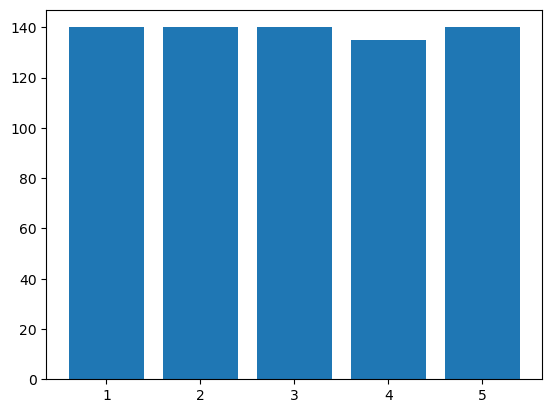

In [92]:
from collections import Counter
from matplotlib import pyplot
counter = Counter(ys)
for k, v in counter.items():
  per = v/len(ys)*100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [93]:
print(X_trains.shape)
print(y_trains.shape)
print(' ')
print(X_tests.shape)
print(y_tests.shape)

(556, 877)
(556,)
 
(139, 877)
(139,)


In [94]:
print("\n\n***********Model Building  - Smote & bag of words ***********\n")
#get the defind models
smoteBasemodel=BaseModeltraning()
bmodelsmote = smoteBasemodel.GetBasedModel()
#get cross validation result of base models
bmsnames,bmscvresults,bmstrainscore,bmstestscore,bmsprecision_score,bmsrecall_score,bmsf1_score =smoteBasemodel.Modelvalidation(X_trains, y_trains, X_tests, y_tests,bmodelsmote,38)
#Formating the results
smotemodelscore=smoteBasemodel.scoringtab(bmodelsmote,bmscvresults,bmstrainscore,bmstestscore,bmsprecision_score,bmsrecall_score,bmsf1_score)



***********Model Building  - Smote & bag of words ***********



------ Defining 7 base Models------

[('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ('NB', GaussianNB()), ('SVM', SVC()), ('CART', DecisionTreeClassifier()), ('AB', AdaBoostClassifier()), ('RF', RandomForestClassifier())]




------ Model validation ------

LR: CV-0.697931 ,Train-0.924460 ,Test-0.683453 ,Precision -0.690000 ,Recall-0.680000 ,F1-Score-0.680000
KNN: CV-0.562919 ,Train-0.667266 ,Test-0.611511 ,Precision -0.730000 ,Recall-0.610000 ,F1-Score-0.530000
NB: CV-0.757227 ,Train-0.955036 ,Test-0.776978 ,Precision -0.780000 ,Recall-0.780000 ,F1-Score-0.780000
SVM: CV-0.766187 ,Train-0.996403 ,Test-0.741007 ,Precision -0.770000 ,Recall-0.740000 ,F1-Score-0.740000
CART: CV-0.590015 ,Train-0.998201 ,Test-0.611511 ,Precision -0.590000 ,Recall-0.610000 ,F1-Score-0.590000
AB: CV-0.374201 ,Train-0.543165 ,Test-0.503597 ,Precision -0.480000 ,Recall-0.500000 ,F1-Score-0.450000
RF: CV-0.719417 ,Train-0.99820

In [95]:
smotemodelscore['Modelname']='Smote - '+smotemodelscore['Modelname']
smotemodelscore

,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score
0,Smote - LR,69.79,0.92,0.68,0.69,0.68,0.68
1,Smote - KNN,56.29,0.67,0.61,0.73,0.61,0.53
2,Smote - NB,75.72,0.96,0.78,0.78,0.78,0.78
3,Smote - SVM,76.62,1.00,0.74,0.77,0.74,0.74
4,Smote - CART,59.00,1.00,0.61,0.59,0.61,0.59
5,Smote - AB,37.42,0.54,0.50,0.48,0.50,0.45
6,Smote - RF,71.94,1.00,0.75,0.76,0.75,0.75


<b>With SMote accuracy of the model is improved twice the previous model. 
    
Among them SVM performs far better than all with 81% precision score and 79.8% test accuracy</b>

In [96]:
smotemodelscore.iloc[3]

Modelname          Smote - SVM
CV Score                 76.62
Train Score                1.0
Test Score                0.74
Precision Score           0.77
Recall Score              0.74
F1 Score                  0.74
Name: 3, dtype: object

## Step 1: Design, train and test Neural networks classifiers

In [97]:
import tensorflow
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, Dropout, Flatten, GlobalAveragePooling1D, BatchNormalization, LSTM, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TimeDistributed

#### Preparing dependent and independent variables for neural networks

In [98]:
X = df1['x']
# Converting the target to one hot for keras model
y = pd.get_dummies(df['Potential Accident Level']).values
# Spliting the Data for Neural Networks Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =1, shuffle=True)

In [99]:
# Defining the parameters and indices for words
max_features = 10000 # Initiating with 10000 features
tokenizer = Tokenizer(num_words= max_features)
# Fitting the tokenizer on Training input feature
tokenizer.fit_on_texts(X_train.tolist())
print(tokenizer.word_index) # Words with its index
len(tokenizer.word_index)
# Printing features before tokenizer
print(X_train[10])
X_train = tokenizer.texts_to_sequences(X_train.tolist())
print(X_train[10])
X_test = tokenizer.texts_to_sequences(X_test.tolist())
# Define maximum number of words to consider in each text
max_description_len = max([len(i.split()) for i in df['Cleaned Desc']])
print('Max description length:', max_description_len)
maxlen = max_description_len

# Pad training text
X_train = pad_sequences(X_train, maxlen= maxlen, padding='pre', truncating='post')

# Pad testing text
X_test = pad_sequences(X_test, maxlen= maxlen, padding='pre', truncating='post')
num = np.random.randint(0, X_train.shape[0])
print(X_train[10])

{'local': 1, 'country': 2, 'male': 3, 'employee': 4, '01': 5, 'others': 6, 'third': 7, 'party': 8, 'mining': 9, 'the': 10, 'hand': 11, 'causing': 12, 'right': 13, '02': 14, 'left': 15, 'metals': 16, 'at': 17, 'operator': 18, '03': 19, 'time': 20, 'activity': 21, 'moment': 22, 'injury': 23, 'equipment': 24, 'area': 25, 'work': 26, 'fall': 27, 'level': 28, 'pipe': 29, 'in': 30, 'worker': 31, 'one': 32, 'floor': 33, 'accident': 34, 'finger': 35, 'hit': 36, 'collaborator': 37, 'assistant': 38, 'during': 39, 'support': 40, '05': 41, 'when': 42, 'mr': 43, 'safety': 44, 'mesh': 45, 'remote': 46, '04': 47, 'cm': 48, 'rock': 49, 'part': 50, 'approximately': 51, 'side': 52, 'cut': 53, '06': 54, 'metal': 55, 'truck': 56, 'height': 57, 'described': 58, 'team': 59, '10': 60, 'kg': 61, 'used': 62, 'face': 63, 'injured': 64, 'place': 65, 'foot': 66, 'medical': 67, 'circumstance': 68, 'platform': 69, 'meter': 70, 'performing': 71, 'two': 72, 'using': 73, 'end': 74, 'point': 75, 'access': 76, 'x': 77, 

#### Glove embedding

In [100]:
import gensim
import gensim.downloader as api
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec, KeyedVectors
# Glove file - we are using model with 200 embeddings
glove_input_file = 'glove.6B.200d.txt'

# Name for word2vec file
word2vec_output_file = 'glove.6B.200d.txt.word2vec'

# Converting glove embedding to word2vec embedding
glove2word2vec(glove_input_file, word2vec_output_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
# Getting Pre-trained embedding
embedding_vector_length= glove_model.vector_size
print("embedding_vector_length",embedding_vector_length)
vocab_size = len(tokenizer.word_index)+1
print("vocab_size",vocab_size)
num_words = min(max_features, vocab_size)
print("num_words",num_words)
embedding_matrix = np.zeros((num_words, embedding_vector_length))
print("embedding_matrix shape",embedding_matrix.shape)

embedding_vector_length 200
vocab_size 2720
num_words 2720
embedding_matrix shape (2720, 200)


In [101]:
#Loading word vectors for each word from glove Word2Vec model
for word, i in sorted(tokenizer.word_index.items(),key=lambda x:x[1]):
    if i > (num_words):
        break
    try:
        embedding_vector = glove_model[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass
    
num = np.random.randint(0, embedding_matrix.shape[0])

In [102]:
embedding_vector_length

200

#### Neural networks design

In [103]:
nn_model = Sequential()
# Embedding layer
nn_model.add(Embedding(input_dim= num_words, output_dim= embedding_vector_length,weights = [embedding_matrix],trainable = False,input_length = maxlen)) 
# Flatten the data as will use Dense layer
nn_model.add(Flatten())

# Adding Hidden Layers(Dense layers)
nn_model.add(Dense(100, activation='relu', input_shape=()))
nn_model.add(Dropout(0.4))
nn_model.add(BatchNormalization())
nn_model.add(Dense(50, activation='relu')) 
nn_model.add(Dropout(0.4))
nn_model.add(BatchNormalization())
nn_model.add(Dense(25, activation='relu'))
nn_model.add(Dropout(0.4))
# Adding output layer
nn_model.add(Dense(5, activation='softmax'))
# Compiling the model
nn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 200)           544000    
                                                                 
 flatten (Flatten)           (None, 19800)             0         
                                                                 
 dense (Dense)               (None, 100)               1980100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                        

#### Training the neural network

In [104]:
# Using callback function to stop the model the loss is not reducing or accuracy is not improving
early = EarlyStopping(monitor='val_loss', patience=7, verbose=1,min_delta=0.0001,  mode='auto') # min_delta=0.0001,
reduce_learning = ReduceLROnPlateau(patience=5, verbose=1, min_lr=1e-6, factor=0.2)
callback_list = [early, reduce_learning]
nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks= [callback_list])

Epoch 1/100
11/11 [==============================] - 4s 47ms/step - loss: 2.1540 - accuracy: 0.2305 - val_loss: 1.6784 - val_accuracy: 0.2024 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 1.9535 - accuracy: 0.2395 - val_loss: 1.6431 - val_accuracy: 0.2262 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 26ms/step - loss: 1.7493 - accuracy: 0.3054 - val_loss: 1.6152 - val_accuracy: 0.2024 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 27ms/step - loss: 1.6654 - accuracy: 0.3413 - val_loss: 1.6122 - val_accuracy: 0.1905 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 27ms/step - loss: 1.6033 - accuracy: 0.3533 - val_loss: 1.5789 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 27ms/step - loss: 1.5985 - accuracy: 0.3802 - val_loss: 1.5714 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 26ms/step - lo

#### Function for Performance Metrix

In [105]:
# Printing the performance matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def print_confusion_matrix(y_test, ytest_predict):
    cm = confusion_matrix(y_test, ytest_predict)
    cm = pd.DataFrame(cm)

    plt.figure(figsize=(5,5))
    sns.set()
    sns.heatmap(cm.T, square=True, fmt='', annot=True, cbar=False, cmap='plasma',
              xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5']).set_title('Confusion Matrix')
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

#### Testing the neural Network

11/11 [==============================] - 0s 4ms/step


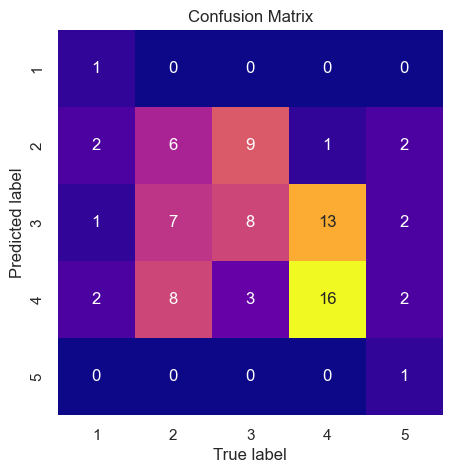

              precision    recall  f1-score   support

           1       1.00      0.17      0.29         6
           2       0.30      0.29      0.29        21
           3       0.26      0.40      0.31        20
           4       0.52      0.53      0.52        30
           5       1.00      0.14      0.25         7

    accuracy                           0.38        84
   macro avg       0.61      0.31      0.33        84
weighted avg       0.48      0.38      0.38        84



In [106]:


ytest_predict = nn_model.predict(X_test)
ytest_predict_binary = ytest_predict >= 0.5
ytrain_predict = nn_model.predict(X_train)
ytrain_predict_binary = ytrain_predict >= 0.5
print_confusion_matrix(y_test.argmax(axis=1), ytest_predict.argmax(axis=1))
print(classification_report(y_test.argmax(axis=1), ytest_predict.argmax(axis=1), target_names=['1','2','3','4','5']))

#### Scoring Table

In [107]:
Y_true=y_test.argmax(axis=1)
y_pred=ytest_predict.argmax(axis=1)
auctest = accuracy_score(Y_true, y_pred)

Y_traintrue=y_train.argmax(axis=1)
y_trainpred=ytrain_predict.argmax(axis=1)
auctrain = accuracy_score(Y_traintrue, y_trainpred)
p=precision_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
r=recall_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
f=f1_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
nnresult={'Modelname':'Neural Network','CV Score': '','Train Score': auctrain,'Test Score': auctest,'Precision Score': p,'Recall Score': r,'F1 Score': f}

In [108]:
Mlmodel2=Mlmodel2.append(nnresult, ignore_index=True, verify_integrity=False, sort=None)

In [109]:
nnresult

{'Modelname': 'Neural Network',
 'CV Score': '',
 'Train Score': 0.8592814371257484,
 'Test Score': 0.38095238095238093,
 'Precision Score': 0.48,
 'Recall Score': 0.38,
 'F1 Score': 0.38}

## Step 2: Design, train and test RNN or LSTM classifiers 

#### Deisgning the LSTM network

In [110]:
LSTM_model = Sequential()
# Embedding layer
LSTM_model.add(Embedding(input_dim= num_words, output_dim= embedding_vector_length,
                          weights = [embedding_matrix],
                          trainable = False,
                          input_length = maxlen)) 
# Adding the Bidirectional LSTM layer 
LSTM_model.add(Bidirectional(LSTM(100, return_sequences = True, dropout= 0.4))) #50

# Adding global pooling to make it 1D
LSTM_model.add(GlobalMaxPooling1D())

# Adding dropout to avoid overfitting 
LSTM_model.add(Dropout(0.4))

# Adding output layer
LSTM_model.add(Dense(5, activation = 'softmax'))
# Compiling the model
LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 99, 200)           544000    
                                                                 
 bidirectional (Bidirectiona  (None, 99, 200)          240800    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 785,805
Trainable params: 241,805
Non-tr

#### Training the LSTM network

In [111]:
# Using callback function to stop the model the loss is not reducing or accuracy is not improving
early = EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1, mode='auto')
reduce_learning = ReduceLROnPlateau(patience=15, verbose=1, min_lr=1e-6, factor=0.2)
model_cp = ModelCheckpoint('Industrial_chatbot.h5',monitor='val_loss', save_best_only= True, verbose=1,)
callback_list = [early, reduce_learning, model_cp]
# may be run for more epochs
LSTM_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, callbacks= [callback_list])

Epoch 1/30
10/11 [==========================>...] - ETA: 0s - loss: 1.5632 - accuracy: 0.3000
Epoch 1: val_loss improved from inf to 1.45620, saving model to Industrial_chatbot.h5
11/11 [==============================] - 4s 154ms/step - loss: 1.5719 - accuracy: 0.2934 - val_loss: 1.4562 - val_accuracy: 0.3571 - lr: 0.0010
Epoch 2/30
10/11 [==========================>...] - ETA: 0s - loss: 1.4819 - accuracy: 0.3406
Epoch 2: val_loss improved from 1.45620 to 1.44831, saving model to Industrial_chatbot.h5
11/11 [==============================] - 1s 90ms/step - loss: 1.4840 - accuracy: 0.3413 - val_loss: 1.4483 - val_accuracy: 0.3571 - lr: 0.0010
Epoch 3/30
10/11 [==========================>...] - ETA: 0s - loss: 1.4316 - accuracy: 0.3719
Epoch 3: val_loss improved from 1.44831 to 1.40221, saving model to Industrial_chatbot.h5
11/11 [==============================] - 1s 93ms/step - loss: 1.4296 - accuracy: 0.3743 - val_loss: 1.4022 - val_accuracy: 0.3810 - lr: 0.0010
Epoch 4/30
10/11 [====

#### Performance Metrics Of LSTM

Text(0.5, 1.0, 'Validation Loss')

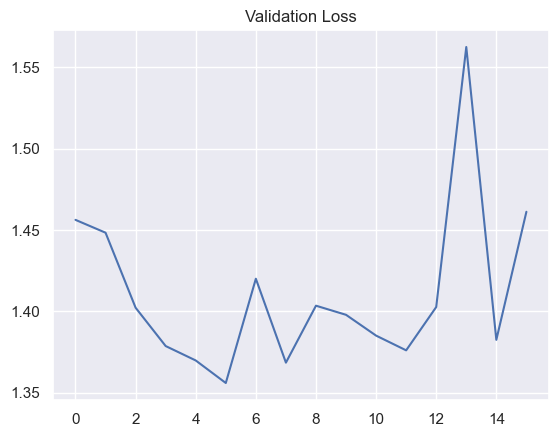

In [112]:

# Checking the history of the model
plt.plot(LSTM_model.history.history['val_loss']);
plt.title("Validation Loss")

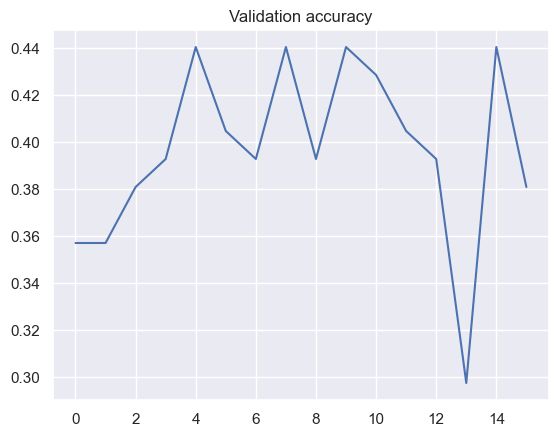

In [113]:
# Checking the history of the model
plt.plot(LSTM_model.history.history['val_accuracy']);
plt.title("Validation accuracy");

#### Testing the Model

3/3 [==============================] - 0s 27ms/step - loss: 1.4612 - accuracy: 0.3810
Test accuracy of the model:38.10%
11/11 [==============================] - 0s 25ms/step


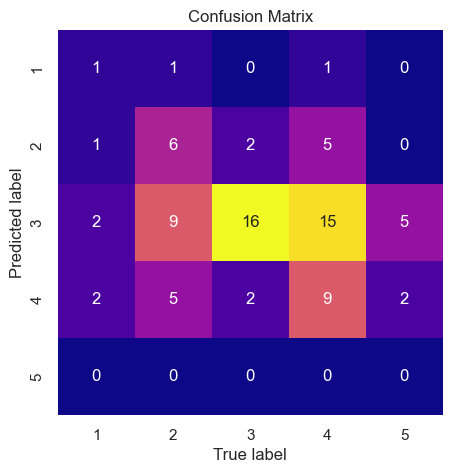

              precision    recall  f1-score   support

           1       0.33      0.17      0.22         6
           2       0.43      0.29      0.34        21
           3       0.34      0.80      0.48        20
           4       0.45      0.30      0.36        30
           5       0.00      0.00      0.00         7

    accuracy                           0.38        84
   macro avg       0.31      0.31      0.28        84
weighted avg       0.37      0.38      0.34        84



In [114]:

# Evaluating the model
test_result = LSTM_model.evaluate(X_test, y_test)
print('Test accuracy of the model:{0:.2%}'.format(test_result[1]))
ytest_predict = LSTM_model.predict(X_test)
ytest_pred_binary = ytest_predict>=0.5


ytrain_predict = LSTM_model.predict(X_train)
ytrain_predict_binary = ytrain_predict >= 0.5

print_confusion_matrix(y_test.argmax(axis=1), ytest_predict.argmax(axis=1))
print(classification_report(y_test.argmax(axis=1), ytest_predict.argmax(axis=1), target_names=['1','2','3','4','5']))

#### Scoring Table

In [115]:
Y_true=y_test.argmax(axis=1)
y_pred=ytest_predict.argmax(axis=1)
auctest = accuracy_score(Y_true, y_pred)

Y_traintrue=y_train.argmax(axis=1)
y_trainpred=ytrain_predict.argmax(axis=1)
auctrain = accuracy_score(Y_traintrue, y_trainpred)
p=precision_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
r=recall_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
f=f1_score(Y_true, y_pred, average='weighted',zero_division=1).round(2)
lstmresult={'Modelname':'LSTM Network','CV Score': '','Train Score': auctrain,'Test Score': auctest,'Precision Score': p,'Recall Score': r,'F1 Score': f}

In [116]:
Mlmodel2=Mlmodel2.append(lstmresult, ignore_index=True, verify_integrity=False, sort=None)

In [117]:
lstmresult

{'Modelname': 'LSTM Network',
 'CV Score': '',
 'Train Score': 0.7904191616766467,
 'Test Score': 0.38095238095238093,
 'Precision Score': 0.46,
 'Recall Score': 0.38,
 'F1 Score': 0.34}

## Step 3: Choose the best performing classifier and pickle it.

In [127]:
#Consolidated score board of models which is trained with all the columns [] and predicted potential accident level is
Finalmodels=pd.concat([Mlmodel2,smotemodelscore], ignore_index=True)
Finalmodels.sort_values(['Test Score','Precision Score'],ascending = [False, False])


,Modelname,CV Score,Train Score,Test Score,Precision Score,Recall Score,F1 Score
32,Smote - NB,75.72,0.960000,0.780000,0.78,0.78,0.78
36,Smote - RF,71.94,1.000000,0.750000,0.76,0.75,0.75
33,Smote - SVM,76.62,1.000000,0.740000,0.77,0.74,0.74
30,Smote - LR,69.79,0.920000,0.680000,0.69,0.68,0.68
31,Smote - KNN,56.29,0.670000,0.610000,0.73,0.61,0.53
34,Smote - CART,59.0,1.000000,0.610000,0.59,0.61,0.59
35,Smote - AB,37.42,0.540000,0.500000,0.48,0.50,0.45
6,Bag of Words - RF,44.61,1.000000,0.490000,0.53,0.49,0.44
3,Bag of Words - SVM,42.53,0.950000,0.400000,0.52,0.40,0.40
0,Bag of Words - LR,45.5,1.000000,0.400000,0.42,0.40,0.41


### Best Model

In [119]:
#best Model
Finalmodels.iloc[33]

Modelname          Smote - SVM
CV Score                 76.62
Train Score                1.0
Test Score                0.74
Precision Score           0.77
Recall Score              0.74
F1 Score                  0.74
Name: 33, dtype: object

<b> Reason : Cross validation score is high for SVM comapred to NB and RF</b>

#### Tuning the best Model

In [120]:
#Training the SVm with best parameters

hyperparameters={"C":[0.1, 0.5],"kernel":[ 'rbf' , 'sigmoid' ]}
gcv = GridSearchCV(SVC(),hyperparameters,cv=5,verbose=3,n_jobs=-1,)
best_modeltune = gcv.fit(X_trains, y_trains)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [121]:
message = ('SVC()',best_modeltune.best_score_, best_modeltune.best_params_)
print("%s -Best: %f using %s" % (message))

SVC() -Best: 0.712130 using {'C': 0.5, 'kernel': 'rbf'}


### Scoring table of Best Model

In [130]:
bestmodel=SVC(C= 0.5,kernel= 'rbf')
bestmodel.fit(X_trains, y_trains)
Y_true, y_pred = y_tests, bestmodel.predict(X_tests) #prediction with test data
Y_traintrue, ytrain_pred = y_trains, bestmodel.predict(X_trains) #prediction with train data
#Training and testing scores
print("Test Accuracy ",accuracy_score(Y_true, y_pred))
print("Train Accuracy ",accuracy_score(Y_traintrue, ytrain_pred))
print("precision_score ",precision_score(Y_true, y_pred, average='weighted',zero_division=1).round(2))
print("Recall ",recall_score(Y_true, y_pred, average='weighted',zero_division=1).round(2))
print("F1 ",f1_score(Y_true, y_pred, average='weighted',zero_division=1).round(2))

Test Accuracy  0.7482014388489209
Train Accuracy  0.9514388489208633
precision_score  0.79
Recall  0.75
F1  0.75


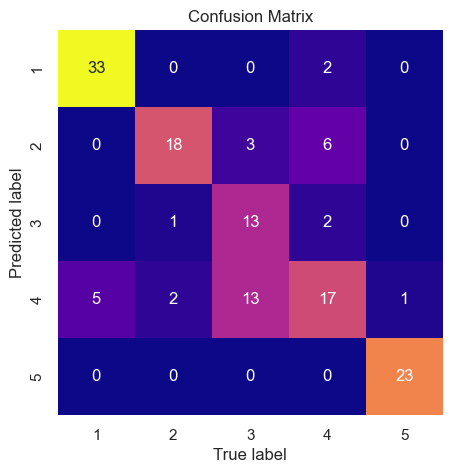

In [123]:
print_confusion_matrix(y_tests, y_pred)

### Packing the best Model

In [124]:
with open('industrysafe.pickle','wb') as pkl:
    pickle.dump(bestmodel,pkl)
    

# Prediction API using FLASK

In [125]:
from flask import Flask,render_template,url_for,request,jsonify
import pickle
app = Flask(__name__)

@app.route('/')
def home():
    return "Hai , Im a accident level detection Bot"

@app.route('/predict',methods=['POST','GET'])

def predict():
    def preprocess_text(text):

        #stopwords removal
        Cleandesc=  ' '.join([words for words in text.split() if words not in stop]) 

        #lemmetization
        lemmatizer = WordNetLemmatizer()
        Cleandesc= ' '.join([lemmatizer.lemmatize(word) for word in Cleandesc.split(" ")])

        #Convert to lowercase
        Cleandesc= Cleandesc.lower()

        #Remove Special characters and Numbers
        pattern = r'([^a-zA-Z\s]+?)'
        Cleandesc = re.sub(pattern,"",Cleandesc)

        # remove extra white spaces
        Cleandesc = Cleandesc.strip()

        return Cleandesc





    #if request.method == 'POST':
    new_complaint =request.form['message']
    stop=set(stopwords.words('english')) 
    print(new_complaint)
    Cleandesc= preprocess_text(new_complaint)
    #Load it later
    loaded_vec = TfidfVectorizer(ngram_range=(1,2), analyzer='word', min_df=5, sublinear_tf=True,vocabulary=pickle.load(open("vectors.pkl", "rb")))
    prepdesc = loaded_vec.fit_transform(np.array([Cleandesc])).toarray()
    prediction = model.predict(prepdesc)
        

    return jsonify({"Potential accident level":str(prediction[0])})



if __name__ == '__main__':
    modelfile='industrysafe.pickle'
    model = pickle.load(open(modelfile, 'rb'))
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


# Conclusion

To predict the accident level  we explored;

<u>**Feature selection** :</u>

1. predicting accident level y with description as x variable .
2. Predict Potential accident level[*P.A.Level*] with Description as X variable
3. Predicting P.A.Level with Country,Local,IndustrySector,Gender,Employeetype,CriticalRisk and Description
  
    Since all the accident level of samples are lesser than potential accident levels. we assumed that predicting the potential accident level is enough to overcome the situation and using other feature along with description gives good results. 
    
    <b>Hence, x=Country,Local,IndustrySector,Gender,Employeetype,CriticalRisk and Description and y=Potential accident level is selected</b>
    


<u>**Vectorizer Selection**:</u>

Below are the five vectorizing technique tried
    
1. Bag of words
2. TFIDF
3. CBOW
4. word2Vec - Skip1gram
5. Glove embedding 
    
   **TFIDF with parameters ngram_range=(1,2), analyzer='word', min_df=5, sublinear_tf=True are giving best results**
    
 
 
 
 
 <u>**Prediction Model selection**</u>
 
 Below are the machine learning and deep learning models explored
 
 1. Logistic Regression
 2. KNN
 3. Naive Bayes
 4. SVM
 5. Decision Tree
 6. Ada-Boosting
 7. Random Forest
 8. Neural network with 3 hidden layers and Relu activation function
 9. Bidirection LSTM is used
 
 ***Among them SVM gave good cross validation score of 76.62***
 
 
 
 
 
<u> **Sampling Techniques**</u>
 
 Tried Oversampling for minority class [1,2,3,5] and undersampling for class [4]
 
 **After sampling the data there is 40-50% increase in accuracy **
 
 
 
 <u>**Tuning the best model**</u>
 
 After finalizing data preparation techiniques and base model building we have se;lected SVm as best model and tuned SVm with hyperparameters={"C":[0.1, 0.5],"kernel":[ 'rbf' , 'sigmoid' ]} using grid search CV.
 
 
 **Best Parameters turned to be SVC()  using {'C': 0.5, 'kernel': 'rbf'} with results**
 
 
        Test Accuracy  0.7482014388489209
        Train Accuracy  0.9514388489208633
        precision_score  0.79
        Recall  0.75
        F1  0.75
        
        
        
Developed a flask prediction API that can be consumed in Chat application

## Future Improvements


As part of further improvement we will try

    1.Transfer learning of bidirectional LSTM by removing the output layer and saving the last layer result and passing that learning to the best performing SVM classifier to earn more deep and best learning of the model.
    2. Developing a chat application for user interface to predict the accident level
    3. collecting more samples for industry safety domain because we had only  425 samples in raw data before sampling
    4. Also we are aware that Chat GPT have better intelligence to respond to user queries and data processing . we must try to integrate our application with chat GPT for better results.

